# Introduction
The Discounted Cash Flow (DCF) Model is one of the most commonly used methods to value equity.
It is based on the principle that the value of any asset is equal to the present value of the cash flows that it generates in the future.
In this project, we will be building a DCF Model to predict the equity price of a company using Python,
which can help people interested in finance to have an automatic and easy to use technical toolkit in
understanding the predicted future stock price of a company.

# 1. Load Packages and Obtain data

In [2]:
pip install PySimpleGUI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.7/512.7 kB 19.0 MB/s eta 0:00:00


In [56]:
# Import the necessary packages.
# Note that you may need to install some packages, e.g., yfinance.
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import urllib.request as ur
from urllib.request import urlopen
import yfinance as yf
import numpy as np
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from datetime import datetime
import plotly.express as px
import seaborn as sns
import PySimpleGUI as sg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import math
import numpy as np
import random
from collections import deque


First, we create a series of empty lists to store the data,
which will be used to create a dataframe later.
These are important categories in a DCF model to calculate unlevered free cash flow.

In [57]:
Revenue_list = []
# Store the revenue data
Operating_Income_list = []
# Store the operating income data
Income_Tax_List = []
# Store the income tax data
Net_Profit_After_Tax_list = []
# Store the net profit after tax data
# calculated by operating income-tax
Depreciation_Amorization_list = []
# Store the depreciation and amortization data
Stock_Based_Compensation_list = []
# Store the stock based compensation data
Change_in_Operating_Assets_list = []
# Store the change in operating assets data
Operating_Cash_Flow_list = []
# Store the operating cash flow data
# calculated by net profit after tax+depreciation+stock based compensation+change in operating assets
Capital_Expense_list = []
# Store the capital expense data
Free_Cash_Flow_list = []
# Store the free cash flow data
#calculated by operating cash flow-capital expense
time_list = []
# store the time for each data point

Next, We will be using the financialmodelingprep.com API to get the data.

financialmodelingprep.com is a free API that provides financial data for companies.

The API key is required to access the data.

You can get your own API key by registering at https://financialmodelingprep.com/developer

In [60]:
# We will be using ticker to indicate what company stock you are looking for.
# e.g. ticker = 'AAPL' for Apple Inc.
# ticker is basically a abbreviation for a company stock.
ticker=input("Please enter your ticker: ")
# Some parameters that will be useful for data acquisition.

# This is the maximum number of years we can retrieve.
limit=20
# This is the number of years of data we want to look at.
pastyear=5
# current year
nowyear=2023
# set the time period to annual
# Period can be ttm(trailing twelve month) | annual | quarter.
period='annual'
# we are only using the free version, so we can only get annual/ttm data.
# If you want to see quarter, you need to purchase the premium version.


# This is the API key for financialmodelingprep.com
key = 'db6297f43527b1304c6628850f3da056'

def get_income_statement(ticker, limit, key, period):
    """Function to Get the Income Statement."""
    # Set the Income-statement URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/income-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}?limit={}&apikey={}'.format(URL,
                                                       ticker,
                                                       period,
                                                       limit,
                                                       key))
        # Convert the data into a dataframe
        incomeStatement = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        incomeStatement.columns = incomeStatement.iloc[0]
        # Drop the first row
        return incomeStatement[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Income statement sheet ERROR: ', str(e))

def get_balance_sheet(ticker, limit, key, period):
    """Get the Balance sheet."""
    # Set the Balance Sheet URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/balance-sheet-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}&?limit={}&apikey={}'.format(URL,
                                                        ticker,
                                                        period,
                                                        limit,
                                                        key))
        # Convert the data into a dataframe
        balanceSheet = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        balanceSheet.columns = balanceSheet.iloc[0]
        # Drop the first row
        return balanceSheet[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Balance sheet statement ERROR: ', str(e))



def get_cash_flow_statement(ticker, limit, key, period):
    """Get the Cash flow statements."""
    # Set the cash flow statements URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/cash-flow-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}&?limit={}&apikey={}'.format(URL,
                                                        ticker,
                                                        period,
                                                        limit,
                                                        key))
        # Convert the data into a dataframe
        cashFlow = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        cashFlow.columns = cashFlow.iloc[0]
        # Drop the first row
        return cashFlow[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Cash flow statement ERROR: ', str(e))


def get_financial_ratios(ticker, limit, key, period):
    """Get the Financial ratios."""
    """Period is ttm | annual | quarter."""
    # Set the URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/'
    # If the period is ttm, then we need to use different columns than quarter/annual
    if period == "ttm":
        # Get the data from the API
        try:
            r = requests.get(
                '{}/ratios-ttm/{}?{}&apikey={}'.format(URL,
                                                       ticker,
                                                       period,
                                                       key))
            # Convert the data into a dataframe
            fr = pd.DataFrame.from_dict(r.json()).transpose()
            # column names are ticker name + TTM Ratios
            fr.columns = [ticker + " TTM Ratios"]
            return fr
        # If there is an error, print the error
        except requests.exceptions.HTTPError as e:
            print('Requesting Financial ratios ERROR(1): ', str(e))
    # If the period is annual/quarter, then we need to use different columns than ttm
    elif period == "annual" or period == "quarter":
        try:
            # Get the data from the API
            r = requests.get(
                '{}ratios/{}?period={}&?limit={}&apikey={}'.format(URL,
                                                                   ticker,
                                                                   period,
                                                                   limit,
                                                                   key))
            # Convert the data into a dataframe
            fr = pd.DataFrame.from_dict(r.json()).transpose()
            # Set the column names to the second row
            fr.columns = fr.iloc[1]
            # Drop the first two rows
            return fr[2:]
        # If there is an error, print the error
        except requests.exceptions.HTTPError as e:
            print('Requesting Financial ratios ERROR(2): ', str(e))
    # If the period is not ttm/annual/quarter, then we need to print an error
    else:
        print('ERROR: Define the period you want: ttm | annual | quarter')
        return None

def get_key_metrics(ticker, limit, key, period):
    """
    Get the key metrics of a company such as Market capitalization, PE ratio, Price
    to sale ration, etc.
    ticker: the ticker of the company
    limit: the number of years of key metrics
    key: the API key
    period: the period of the key metrics: ttm | annual | quarter
    (quarterly is only avaliable for subscribers)

    Return: a dataframe of the key metrics
    """

    URL = 'https://financialmodelingprep.com/api/v3/'
    if period == "ttm":
        try:
            r = requests.get(
                '{}key-metrics-ttm/{}?apikey={}'.format(URL, ticker, key))
            #get the data from the API
            km = pd.DataFrame.from_dict(r.json()).transpose()
            #convert the data into a dataframe and transpose the dataframe
            km.columns = [ticker + " TTM Ratios"] #rename the column
            return km
        except requests.exceptions.HTTPError as e:
            print('Requesting Key Metrics ERROR(1): ', str(e))
    elif period == "annual" or period == "quarter":
        try:
            r = requests.get(
                '{}key-metrics/{}?period={}&?limit={}&apikey={}'.format(URL,
                                                                        ticker,
                                                                        period,
                                                                        limit,
                                                                        key))
            km = pd.DataFrame.from_dict(r.json()).transpose()
            km.columns = km.iloc[1]
            return km[2:]
        except requests.exceptions.HTTPError as e:
            print('Requesting Key Metrcs ERROR(2): ', str(e))
    else:
        print('ERROR: Define the period you want: ttm | annual | quarter')
        return None

def get_enterprise_value(ticker, rate, key, period):
    """
    The function creates a dataframe of the enterprise value of a company based on the company's finance statement.
    It is calculated from market value.
    ticker: the ticker of the company
    rate: the number of years of enterprise value
    key: the API key
    period: the period of the enterprise value: ttm | annual | quarter
    Return: a dataframe of the enterprise value
    """
    URL = 'https://financialmodelingprep.com/api/v3/enterprise-values/'
    try:
        r = requests.get('{}{}?period={}&limit={}&apikey={}'.format(URL,
                                                                    ticker,
                                                                    period,
                                                                    rate,
                                                                    key))
        return pd.DataFrame.from_dict(r.json())
    except requests.exceptions.HTTPError as e:
        print('Requesting Enterprise Value ERROR: ', str(e))

Please enter your ticker: AAPL


Then, we visualize the dataframe that store the results by running the above functions on the designated Stock

In [7]:
df_income_statement=get_income_statement(ticker,limit,key,period)
# Create a dataframe using the get_income_statement function
df_balance_sheet=get_balance_sheet(ticker,limit,key,period)
# Create a dataframe using the get_balance_sheet function
df_cash_flow_statement=get_cash_flow_statement(ticker,limit,key,period)
# Create a dataframe using the get_cash_flow_statement function
key_metrics = get_key_metrics(ticker, limit, key, period)
# Create a dataframe using the get_key_metrics function
df_get_enterprise_value = get_enterprise_value(ticker, rate=10, key=key, period=period)
# Create a dataframe using the get_enterprise_value function

In [8]:
#Displaying Income Statement.
df_income_statement

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
revenue,394328000000,365817000000,274515000000,260174000000,265595000000
costOfRevenue,223546000000,212981000000,169559000000,161782000000,163756000000
grossProfit,170782000000,152836000000,104956000000,98392000000,101839000000


In [9]:
df_balance_sheet
# Displaying Balance Sheet

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
cashAndCashEquivalents,23646000000,34940000000,38016000000,48844000000,25913000000
shortTermInvestments,24658000000,27699000000,52927000000,51713000000,40388000000
cashAndShortTermInvestments,48304000000,62639000000,90943000000,100557000000,66301000000


In [10]:
df_cash_flow_statement
# Displaying Cash Flow Statement

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
netIncome,99803000000,94680000000,57411000000,55256000000,59531000000
depreciationAndAmortization,11104000000,11284000000,11056000000,12547000000,10903000000
deferredIncomeTax,895000000,-4774000000,-215000000,-340000000,-32590000000


In [11]:
key_metrics
# Displaying Key Metrics.

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
period,FY,FY,FY,FY,FY
revenuePerShare,24.317273,21.903541,15.820258,14.085283,13.399334
netIncomePerShare,6.154614,5.669029,3.308587,2.991446,3.003354
operatingCashFlowPerShare,7.532763,6.229346,4.64923,3.756685,3.906565
freeCashFlowPerShare,6.872426,5.565624,4.228014,3.188508,3.23492
cashPerShare,2.978793,3.750553,5.241031,5.443948,3.344902
bookValuePerShare,3.124822,3.777557,3.765477,4.898834,5.405593
tangibleBookValuePerShare,3.124822,3.777557,3.765477,4.898834,5.405593
shareholdersEquityPerShare,3.124822,3.777557,3.765477,4.898834,5.405593
interestDebtPerShare,7.585118,7.626006,6.64524,6.043039,5.939155


In [12]:
df_get_enterprise_value
# Displaying Enterprise Value dataframe.

,symbol,date,stockPrice,numberOfShares,marketCapitalization,minusCashAndCashEquivalents,addTotalDebt,enterpriseValue
0,AAPL,2022-09-24,150.4300,16215963000,2439367314090,23646000000,120069000000,2535790314090
1,AAPL,2022-09-24,150.4300,16215963000,2439367314090,23646000000,120069000000,2535790314090
2,AAPL,2021-09-25,146.9200,16701272000,2453750882240,34940000000,124719000000,2543529882240
3,AAPL,2020-09-26,112.2800,17352119000,1948295921320,38016000000,112436000000,2022715921320
4,AAPL,2019-09-28,54.7050,18471336000,1010474435880,48844000000,108047000000,1069677435880
5,AAPL,2018-09-29,56.4350,19821508000,1118626803980,25913000000,114483000000,1207196803980
6,AAPL,2017-09-30,38.5300,20868968000,804081337040,20289000000,115680000000,899472337040
7,AAPL,2016-09-24,28.1775,21883280000,616616122200,20484000000,87032000000,683164122200
8,AAPL,2015-09-26,28.6775,23013684000,659974922910,21120000000,64462000000,703316922910
9,AAPL,2014-09-27,25.1875,24342288000,613121379000,13844000000,35295000000,634572379000


# 2. Data Processing

Moving on to Data Processing, we first create some lists to store the value of the past few years for specific variables like the company's revenue, operating income, capital expense, and so on.

In [13]:
def make_list_IS(component):
    # Function to create a list of component from Income Statement
    return list(df_income_statement.loc[component][:pastyear].copy().values).copy()

def make_list_CS(component):
     # Function to create a list of component from Cash Flow Statement
    return list(df_cash_flow_statement.loc[component][:pastyear].copy().values).copy()


In [14]:
revenue_list=make_list_IS('revenue')
#Create a list of company's revenue
Operating_Income_List= make_list_IS('operatingIncome')
##Create a list of company's operating income
Income_Tax_List = make_list_IS('incomeTaxExpense')
##Create a list of company's income tax
Depreciation_Amorization_list=make_list_CS('depreciationAndAmortization')
##Create a list of company's depreciation and amortization
Stock_Based_Compensation_list=make_list_CS('stockBasedCompensation')
##Create a list of company's stock based compensation
Operating_Cash_Flow_list = make_list_CS('operatingCashFlow')
##Create a list of company's operating cash flow
Capital_Expense_List=make_list_CS('capitalExpenditure')
##Create a list of company's capital expenditure

In [15]:
#reverse the list of components so that the first element is the oldest revenue in time order
revenue_list.reverse()
Operating_Income_List.reverse()
Income_Tax_List.reverse()
Depreciation_Amorization_list.reverse()
Stock_Based_Compensation_list.reverse()
Operating_Cash_Flow_list.reverse()
Capital_Expense_List.reverse()

time_list=[nowyear-i for i in range(pastyear-1,-1,-1)]
# Create a time list storing the series of time
Present_Year=time_list[0]
#Set the present year that is used to discount the future cashflow


Utilizing the above lists, we can go on to calculate some more complex values such as growth rate and operating_income_margin that are crucial in calculating Free Cash Flow.

In [16]:
growth_rate_list=[]
for i in range(0,len(revenue_list)-1):
    growth_rate_list.append((revenue_list[i+1]-revenue_list[i])/revenue_list[i])
# Create a growth rate list that append the calculated growth rate of revenue.
Operating_Income_margin_list=[]
for i in range(0,len(Operating_Income_List)):
    Operating_Income_margin_list.append(Operating_Income_List[i]/revenue_list[i])
# Create a Operating_Income_margin list that append the calculated percentage of opearting income over revneue.
Net_Profit_After_Tax_list = []
for i in range(0, len(Operating_Income_List)):
    Net_Profit_After_Tax_list.append(Operating_Income_List[i]-Income_Tax_List[i])
# Create a Net operating profit after tax(NOPAT) list that append the result of operating income - income tax.
DA_margin_list = []
for i in range(0, len(Depreciation_Amorization_list)):
    DA_margin_list.append(Depreciation_Amorization_list[i]/revenue_list[i])
# Create a Depreciation & Amortization(D&A) margin list that append the precentage of D&A over revenue
Stock_Based_Compensation_margin_list = []
for i in range(0, len(Stock_Based_Compensation_list)):
    Stock_Based_Compensation_margin_list.append(Stock_Based_Compensation_list[i]/revenue_list[i])
# Create a Stock Based Compensation margin list that append the precentage of Stock Based Compensation over revenue
Change_in_Operating_Assets_list = []
for i in range(0, len(Net_Profit_After_Tax_list)):
    Change_in_Operating_Assets_list.append(Operating_Cash_Flow_list[i]-(Net_Profit_After_Tax_list[i]+Depreciation_Amorization_list[i]+Stock_Based_Compensation_list[i]))
# Create a Change in Operating Assets list calculated by Opearting Cash flow - (NOPAT + D&A + Stock Based Compensation)
Change_in_Operating_Assets_margin_list = []
for i in range(0, len(Change_in_Operating_Assets_list)):
    Change_in_Operating_Assets_margin_list.append(Change_in_Operating_Assets_list[i]/revenue_list[i])
# Create a Change in Operating Assets margin list that append the precentage of Change in Operating Assets over revenue
Capital_Expense_margin_list = []
for i in range(0, len(Capital_Expense_List)):
    Capital_Expense_margin_list.append(Capital_Expense_List[i]/revenue_list[i])
# Create a Capital Expense margin list that append the precentage of Capital Expense over revenue
Free_Cash_Flow_list = []
for i in range(0, len(Operating_Cash_Flow_list)):
    Free_Cash_Flow_list.append(Operating_Cash_Flow_list[i]-abs(Capital_Expense_List[i]))
# Create a Free Cash Flow list calculated by Operating Cash flow - Capital Expense
FCF_Operating_Income_Rate_list = []
for i in range(0, len(Free_Cash_Flow_list)):
    FCF_Operating_Income_Rate_list.append(Free_Cash_Flow_list[i]/Operating_Income_List[i])
# Create the free cash flow to operating income rate list that append the percentage of Free cash flow over operating income

# 3. Data Visualization

After finishing processing the data, we need to visualise the process of our calculation of the Unlevered Free Cash Flow by creating and displaying a pandas data frame. Note that all values that are not in percentage are in millions USD.

In [17]:
growth_rate_list2 = growth_rate_list.copy()
growth_rate_list2.insert(0, 0)
# make a copy of growth rate list and insert a 0 value at the start to make the list have length 5.

In [18]:
print(growth_rate_list2)
print(growth_rate_list)
# displaying the new list & old list

[0, -0.020410775805267418, 0.055120803769784836, 0.33259384733074693, 0.07793787604184606]
[-0.020410775805267418, 0.055120803769784836, 0.33259384733074693, 0.07793787604184606]


In [19]:
# Divisor set up as 1 million to make sure all non-percentage value are shown in millions USD.
divisor = 1000000

# Create a data dictionary to store all the list
# round all percentages to 1 decimal place and add the percentage sign after the numerical value
data = {
'First Step:': ['' for x in Income_Tax_List],
'Revenue': [x/1000000 for x in revenue_list],
'Revenue Growth Rate': [str(np.round(x*100,1)) + '%' for x in growth_rate_list2],
'Operating Income': [x/1000000 for x in Operating_Income_List],
'Operating Margin': [str(np.round(x*100,1)) + '%' for x in Operating_Income_margin_list],
'Second Step:': ['' for x in Income_Tax_List],
'Less: Taxes': [x/1000000 for x in Income_Tax_List],
'Net Opearting Profit After Taxes(NOPAT)': [x/1000000 for x in Net_Profit_After_Tax_list],
'Third Step:': ['' for x in Income_Tax_List],
'Plus: Depreciation and Amortization': [x/1000000 for x in Depreciation_Amorization_list],
' % Revenue1': [str(np.round(x*100,1)) + '%' for x in DA_margin_list],
'Plus: Stock-based Compensation': [x/1000000 for x in Stock_Based_Compensation_list],
' % Revenue2' : [str(np.round(x*100,1)) + '%' for x in Stock_Based_Compensation_margin_list],
'Fourth Step:': ['' for x in Income_Tax_List],
'Change in Operating Assets & Liabilities': [x/1000000 for x in Change_in_Operating_Assets_list],
' % Revenue3': [str(np.round(x*100,1)) + '%' for x in Change_in_Operating_Assets_margin_list],
'Less: Capital Expenditure': [x/1000000 for x in Capital_Expense_List],
' % Revenue4': [str(np.round(x*100,1)) + '%' for x in Capital_Expense_margin_list],
'Last Step:': ['' for x in Income_Tax_List],
'Unlevered Free Cash Flow': [x/1000000 for x in Free_Cash_Flow_list]}
# show the list that does not have length 5 for debugging purpose:
for key in data:
    if len(data[key]) != 5:
        print(key, len(data[key]))

# Create a pd dataframe to store all the list, use time_list as the index, but -1 for every component
# since we are using annual data, and we cannot get the data for the year 2023 that haven't passed.
df = pd.DataFrame(data, index = [x-1 for x in time_list])
# Transpose the dataframe
df = df.transpose()
# Display the dataframe
pd.set_option('display.max_rows', None)

# add title for the datagrame
print('\033[1m' + f'Historical Free Cash Flow for {ticker}')
df

Historical Free Cash Flow for AAPL


,2018,2019,2020,2021,2022
First Step:,,,,,
Revenue,265595.0,260174.0,274515.0,365817.0,394328.0
Revenue Growth Rate,0%,-2.0%,5.5%,33.3%,7.8%
Operating Income,70898.0,63930.0,66288.0,108949.0,119437.0
Operating Margin,26.7%,24.6%,24.1%,29.8%,30.3%
Second Step:,,,,,
Less: Taxes,13372.0,10481.0,9680.0,14527.0,19300.0
Net Opearting Profit After Taxes(NOPAT),57526.0,53449.0,56608.0,94422.0,100137.0
Third Step:,,,,,
Plus: Depreciation and Amortization,10903.0,12547.0,11056.0,11284.0,11104.0


The resulting data frame being displayed fits closely with the Investment Banking Industry Standard Historical Cash Flow Table, saving users a lot of time in extracting data, calculating components, and creating a neat table.

Then, we create data frames to use time series plots to visualize the development trend over time for our interested variables. We visualised four important components: Revenue, Rate of Free Cash Flow Over Operating Income, Revenue Growth Rate, and Rate of FCF over Operating Income.

In [20]:
df_revenue=pd.DataFrame({'time':time_list,'revenue':revenue_list})
# create a dataframe with time as index and revenue as the only column
df_Operating_Income_margin=pd.DataFrame({'time':time_list,'Operating income margin':Operating_Income_margin_list})
# create a dataframe with time as index and Operating Income Margin as the only column
df_FCF_OI_Rate=pd.DataFrame({'time':time_list,'Rate of FCF over Operating Income':FCF_Operating_Income_Rate_list})
# create a dataframe with time as index and Rate of FCF over Operating Income as the only column
time_list2=time_list.copy()
# create a copy of time_list
time_list2.remove(time_list2[-1])
# remove the last element of the new time_list2, since the growth rate list is one element shorter than the time_list
df_growth_rate=pd.DataFrame({'time':time_list2,'Revenue Growth Rate':growth_rate_list})
# create a dataframe with new time list as index and Revenue Growth Rate as the only column

In [21]:
# Visualize the Revenue
fig = px.line(df_revenue,x='time',y='revenue',
title=f'Revenue of {ticker} (in 100 billions)', markers=True)
fig.update_xaxes(dtick="M1")
fig.show()

In [22]:
# Visualise Percentage of Operating income over Revenue
fig = px.line(df_Operating_Income_margin,x = 'time',y = 'Operating income margin',
title = f'Percentage of Operating Income over Revenue of {ticker}', markers=True)
# add title and markers to the plot
fig.update_xaxes(dtick="M1")
# set the x-axis tick to be yearly
fig.show()

In [23]:
# Visualize Revenue Growth Rate
fig = px.line(df_growth_rate,x = 'time',y = 'Revenue Growth Rate',
title = f'Revenue Growth Rate of {ticker}', markers=True)
# add title and markers to the plot
fig.update_xaxes(dtick="M1")
# set the x-axis tick to be yearly
fig.show()

In [24]:
# Visualize percentage of free cash flow over Opearating Income.
fig = px.line(df_FCF_OI_Rate,x = 'time',y = 'Rate of FCF over Operating Income',
title = f'Rate of FCF over Operating Income of {ticker}', markers=True)
# add title and markers to the plot
fig.update_xaxes(dtick="M1")
# set the x-axis tick to be yearly
fig.show()

# 4. Modeling

In this step, we constructed the DCF Model using average growth rate, average operating_Income_margin, and Average FCF to Operating Income Rate. The Visualized result is a data frame displaying the predicted revenue, Operating income, and Free Cash Flow, as well as a chart visualizing the trend of free cash flow and a time series plot of the predicted stock price with the trend of historical stock prices.

To start off, we set the future revenue growth rate, operating income margin, and free cash flow to operating income rate as average of historical values, and create back up lists for later modifications:

In [25]:
choose_growth_rate=sum(growth_rate_list)/len(growth_rate_list)
# calculate the average growth rate and set it as the growth rate of the company in future
choose_Operating_Income_margin_rate=sum(Operating_Income_margin_list)/len(Operating_Income_margin_list)
# calculate the average Operating Income Margin and set it as the Operating Income Margin of the company in future
choose_free_cash_flow_OI_rate=sum(FCF_Operating_Income_Rate_list)/len(FCF_Operating_Income_Rate_list)
# calculate the average Rate of FCF over Operating Income and set it as the Rate of FCF over Operating Income o
prediction_time=4
# set the prediction time to be 4 years

list3=time_list.copy()
# create a new list3 that is a copy of time_list
revenue_list1=revenue_list.copy()
# create a new revenue_list1 that is a copy of revenue_list
Operating_Income_list1=Operating_Income_list.copy()
# create a new Operating_Income_list1 that is a copy of Operating_Income_list
Free_Cash_Flow_list1=Free_Cash_Flow_list.copy()
# create a new Free_Cash_Flow_list1 that is a copy of Free_Cash_Flow_list

Back_Up_Time_List=list(range(list3[-1]+1,list3[-1]+prediction_time+1))
#Create a list for future years of prediction time
list3=list3+list(range(list3[-1]+1,list3[-1]+prediction_time+1))
#Create a list of time from past n years to future years
Back_Up_Free_Cash_Flow=[]
# Create a list for future Free Cash Flow

Then, we pass the projected revenue, operating income, and free cash flow into the back-up lists. Utilizing these list, we can create a data frame of historical + projected value, and utilize the free cash flow list to create a Chart for Free Cash Flow Prediction.

In [26]:
for i in range(0,prediction_time):
    a=revenue_list1[-1]*(1+choose_growth_rate)
    #a is the predicted revenue for the next year
    revenue_list1.append(a)
    # add the predicted revenue to the revenue list
    b=revenue_list1[-1]*(choose_Operating_Income_margin_rate)
    #b is the predicted operating income for the next year
    Operating_Income_list1.append(b)
    # add the predicted operating income to the operating income list
    c=Operating_Income_list1[-1]*(choose_free_cash_flow_OI_rate)
    #c is the predicted free cash flow for the next year
    Free_Cash_Flow_list1.append(c)
    # add the predicted free cash flow to the free cash flow list
    Back_Up_Free_Cash_Flow.append(c)
    # add the predicted free cash flow to the backup free cash flow list


In [27]:
# Create a pd dataframe to store Predicted Revenue, Operating Income, and Unlevered Free Cash Flow

divisor = 1000000
data = {'Revenue': [x/1000000 for x in revenue_list1],
'Operating Income': [x/1000000 for x in Operating_Income_List] + [x/1000000 for x in Operating_Income_list1],
'Unlevered Free Cash Flow': [x/1000000 for x in Free_Cash_Flow_list1]}
# show the list that does not have length 5 for debugging purpose:
for key in data:
    if len(data[key]) != prediction_time + 5:
        print(key, len(data[key]))

df = pd.DataFrame(data, index = [x-1 for x in list3])
df = df.transpose()

display(df)

,2018,2019,2020,2021,2022,2023,2024,2025,2026
Revenue,265595.0,260174.0,274515.0,365817.0,394328.0,438220.822330,486999.373932,541207.487469,601449.529859
Operating Income,70898.0,63930.0,66288.0,108949.0,119437.0,118744.240552,131961.713958,146650.430116,162974.153701
Unlevered Free Cash Flow,64121.0,58896.0,73365.0,92953.0,111443.0,112063.198682,124537.002393,138399.270656,153804.554068


In [28]:
df_future_free_cash_flow=pd.DataFrame({'time':list3,'free cash flow prediction':Free_Cash_Flow_list1})
# create a dataframe with time as index and free cash flow prediction as the only column

In [29]:
# Visualize the historical free cash flow and the projected future free cash flow
fig = px.line(df_future_free_cash_flow,x = 'time',y = 'free cash flow prediction',
title = f'Free cash flow prediction of {ticker} in 100 billions', markers=True)
fig.update_xaxes(dtick="M1")
fig.show()

Then, we extract some important data from enterprise value, balance sheet, and income statement dataframe, and other values of risk free rate, beta, Expected return, and Perpetual growth extracted using API and web-scraping that is crucial in calculation the Discount rate(WACC), Terminal Value of the Company, and finally, estimated stock price of the company.

In [30]:
total_debt=list(df_get_enterprise_value['addTotalDebt'][:1].values)[0]
# Total debt is the aggregate of all the company's debts.
Market_Cap=list(df_get_enterprise_value['marketCapitalization'][:1].values)[0]
# total value of a publicly traded company's outstanding common shares owned by stockholders
# equal to the total value of company's equity.
OutstandingSharing=list(df_get_enterprise_value['numberOfShares'][:1].values)[0]
# The number of shares outstanding is listed on a company's balance sheet as "Capital Stock" and is reported on the
# company's quarterly filings with the US Securities and Exchange Commission.
Interest_Expense=list(df_income_statement.loc['interestExpense'][:1].values)[0]
# Interest expense is the cost of borrowing money.
Long_Term_Debt=list(df_balance_sheet.loc['longTermDebt'][:1].values)[0]
# Long-term debt is debt that matures in more than one year and is often treated differently from short-term debt.
Short_Term_Debt=list(df_balance_sheet.loc['shortTermDebt'][:1].values)[0]
# Short-term debt, also called current liabilities, is a firm's financial obligations that are expected to be paid off
Income_Tax=list(df_income_statement.loc['incomeTaxExpense'].values)[0]
# Income tax expense is the amount of expense that a business recognizes in an accounting period for the taxes owed
Income_Before_Tax=list(df_income_statement.loc['incomeBeforeTax'].values)[0]
# Income before tax is a measure of a company's profitability that looks at pretax earnings, or earnings before taxes.

In [31]:
# Extract Risk-free rate using web-scraping

#  Risk_Free_Rate = 10-year Treasury rate
## Define the URL of the webpage containing the risk-free rate
url = "https://ycharts.com/indicators/10_year_treasury_rate"  # Replace with the actual URL
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}
result = requests.get(url, headers=headers)
# # Send a GET request to fetch the webpage content

# # Parse the HTML content
soup = BeautifulSoup(result.content, "html.parser")
website_data = soup.find_all("div", class_="key-stat-title")
risk_free_rate=str(website_data)[50:54]
risk_free_rate = 0.01 * float(risk_free_rate)

In [32]:
# Fetch Beta using yahoofinance
Beta = yf.Ticker(ticker).info.get('beta') #use the yfinance package to access a company's beta
# Beta is a measure used in fundamental analysis to determine
# the volatility of an asset or portfolio in relation to the overall market.
# The overall market has a benta of 1.0, and individual stocks are ranked
# according to how much they deviate from the market.

In [33]:
# Set expect return
Expect_Return = 0.1
# Expect_Return - Risk-Free Rate = Equity Risk Premium(ERP), taken between 3-10%
# This year, according to https://www.kroll.com/en/insights/publications/cost-of-capital/recommended-us-equity-risk-premium-and-corresponding-risk-free-rates
# The ERP is 6%, so the Expect_Return is 6% + 3.46% = 9.46%, about 0.1.

Expect_Return=float(Expect_Return) # value largely dependent on this.

# Expeted Return is the profit or loss an investor anticipates on an investment
# that has known or anticipated rates of return (RoR). It is calculated by
# multiplying potential outcomes by the chances of them occurring and then
# totaling these results.

# A rate of return (RoR) is the net gain or loss of an investment over a specified time period,
# expressed as a percentage of the investment’s initial cost.

# CAPM Method:
# Expected Return = Risk-Free Rate + Beta * (Market Return - Risk-Free Rate)

In [34]:
# Set Perpetual-Growth
Perpetual_Growth=0.03
# Perpetual growth is the constant rate of growth applied to a firm's
# expected cash flows when calculating its terminal value.

# Calculated by computing the average free cash flow growth rate
# make sure the value is between historical inflation rate of 2-3%
# and the historical GDP growth rate of 4-5%

In [35]:
# Display value of risk-free-rate.
risk_free_rate

0.0383

Next, we use investment banking formulas to calculate Cost of Equity, Required_Return(Discount Rate), Terminal Value, and range of final stock price. We then display the information and visualize the range of price on top of historical price trend.

In [36]:
Weight_of_debt=total_debt/(total_debt+Market_Cap) # Wd Weight of Debt
Weight_of_equity=1-Weight_of_debt #We Weight of Equity

# Assume there's no preferred stock issued,
# so total value of company = total debt + market cap(total equity)

# Weight_of_preferred stock - if we can get the data of preferred stock of the company

Cost_of_Debt=Interest_Expense/(Long_Term_Debt+Short_Term_Debt) #Rd Cost of Debt
# Percentage of total interest relative to the total debt of the company.

Save_after_Tax_Percent=1-(Income_Tax/Income_Before_Tax)
# 1-Percentage of Tax = (1-T) = Saving Rate from Tax
Cost_of_Equity=risk_free_rate+Beta*(Expect_Return-risk_free_rate)
# Calculated according to the Formula: Cost of Equity = Risk-Free Rate + Equity Risk Premium * Levered Beta
# Remember ERP is Expect_Return-risk_free_rate
Required_Return=(Weight_of_debt*Cost_of_Debt*Save_after_Tax_Percent)+(Weight_of_equity*Cost_of_Equity)
# Required_Return=WACC(Weghted Average Cost of Capital)
# Formula: WACC = Cost of Equity * % Equity + Cost of Debt * % Debt * (1 – Tax Rate) + Cost of Preferred Stock * % Preferred Stock
# and we assume there's no preferred stock issued

Terminal_Value=(Back_Up_Free_Cash_Flow[-1]*(1+Perpetual_Growth))/(Required_Return-Perpetual_Growth)
# Terminal Value = Final Year Free Cash Flow * (1 + Growth Rate) / (Discount Rate – Growth Rate).
a=Back_Up_Free_Cash_Flow[-1]
Terminal_Value=(a*(1+Perpetual_Growth))/(Required_Return-Perpetual_Growth)

Back_Up_Free_Cash_Flow.append(Terminal_Value)
#append the predicted Terminal value to the list
Back_Up_Time_List.append(Back_Up_Time_List[-1])
#append the latest time to the time list

period=1
# Set the period number as 1

Present_Value_Total=[]
# Formula: Present Value of Cash Flow = Cash Flow / (1 + Discount Rate) ^ Period Number
for i in range(0,len(Back_Up_Free_Cash_Flow)):
    Present_Value_Now=Back_Up_Free_Cash_Flow[i]/((1+Required_Return)**(i+1))
    Present_Value_Total.append(Present_Value_Now)

Present_Value_Sum=sum(Present_Value_Total)+Terminal_Value/((1+Required_Return)**(prediction_time))

Final_Price=Present_Value_Sum/OutstandingSharing
# Final Price = Present Value of Cash Flow / Outstanding Shares

Final_Price_Between=[]
# Final Price Between = Final Price * (1 + 10%) and Final Price * (1 - 10%)

Final_Price_Between.append(abs(Final_Price)*(1.1)) # optimistic estimate
Final_Price_Between.append(abs(Final_Price)*(0.9)) # pessimsitic estimate

# can use other values/methods to calculate the range of price.


time_of_current=df_cash_flow_statement.loc['operatingCashFlow'].index[0]
# extract the latest reporting time of the cash flow statement
print(f"from respective of current time: {time_of_current} ")
# print the latest reporting time of the cash flow statement
print(f"Reasonable Price Between {np.round(Final_Price_Between[1])} and {np.round(Final_Price_Between[0])}")
# print the range of reasonable price

# Later, we need to turn this statement into a more coherent and understandable investment statement

from respective of current time: 2022-09-24 
Reasonable Price Between 152.0 and 186.0


[*********************100%***********************]  1 of 1 completed


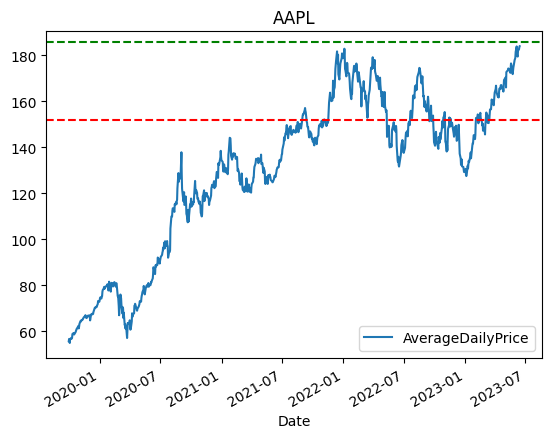

Using Caculated WACC as 0.11371138509705607


In [37]:
# Visualization of range of stock price
start_date = df_cash_flow_statement.loc['operatingCashFlow'].index[3]

data = yf.download(ticker, start_date)
#use yahoo finance to get the historical stock price data

data['AverageDailyPrice']=(data['Open']+data['High'])/2
#create a column for average daily price

ax =data.plot(y='AverageDailyPrice')
plt.title(f"{ticker}")
plt.xlabel(data.index.name)
#plot the average daily price

ax.axhline(y=Final_Price_Between[1], color='red', linestyle='--')
#plot the projected lowest price as the red line
ax.axhline(y=Final_Price_Between[0], color='green', linestyle='--')
#plot the projected highest price as the green line

plt.show()
print("Using Caculated WACC as "+f"{Required_Return}")

Lastly, we present a conclusion to the users indicating our DCF predicted value, reasonable predicted price range, discount value(WACC) at the latest reporting time, and our suggestion of whether to buy or sell based on comparison of the predicted price with the current market price.

In [38]:
Ticker = yf.Ticker(ticker).info
# get the ticker information from yahoo finance
market_price = Ticker['regularMarketPreviousClose']

a = None
b = None
if market_price > Final_Price:
    a = "OVERVALUED"
    b = "SELL"
else:
    a = "UNDERVALUED"
    b = "BUY"

Price_Margin = abs(market_price - Final_Price) / market_price

print(f'''Forecasted by our DCF model, the stock currently have a DCF predicted value of {np.round(Final_Price)},
and a Reasonable Predicted Price Between {np.round(Final_Price_Between[1])} and {np.round(Final_Price_Between[0])}, using Caculated WACC as {np.round(Required_Return,4)}
from respective of the latest statement reporting time: {time_of_current}.
Given its market price of {market_price}, the stock is currently {a} by {np.round(Price_Margin*100,2)} % margin,
and we recommend you to {b} this stock.''')

Forecasted by our DCF model, the stock currently have a DCF predicted value of 169.0, 
and a Reasonable Predicted Price Between 152.0 and 186.0, using Caculated WACC as 0.1137 
from respective of the latest statement reporting time: 2022-09-24. 
Given its market price of 183.31, the stock is currently OVERVALUED by 7.97 % margin, 
and we recommend you to SELL this stock.


# 5. GUI

In this step, we combined all previous component into a simple, easy to use Graphic User Interface(GUI), and after user enter the information requested by the GUI, they can get a complete stock report with financial statements, trend of key values, Projected Free Cash Flow trend and table, DCF result on historical stock trend, and finally, the conclusion indicating our purchasing suggestion.

In [39]:
import PySimpleGUI as sg

sg.theme('DarkAmber')   # Add a touch of color

sg.set_options(text_justification = 'right')

layout = [  [sg.Text('DCF Model Simulation', font='_ 14', justification='c', expand_x=True)],
            [sg.Text('Enter the stock\'s ticker', size = (30,1)), sg.InputText(key = 'ticker')],
            [sg.Text('Enter the limit', size = (30,1)), sg.InputText(key = 'limit')],
            [sg.Text('How many years of data to look at', size = (30,1)), sg.InputCombo((1,2,3,4,5), size = (5, 1), key = 'pastyear')],
            [sg.Text('Enter the current year', size = (30,1)), sg.InputText(key = 'nowyear')],
            [sg.Text('Choose the period', size = (30,1)), sg.InputCombo(('Annual', 'TTM'), size = (10, 1), key = 'period')],
            [sg.Text('Enter your API Key', size = (30,1)), sg.InputText(key = 'key')],
            [sg.Text('_' * 100, size = (100,1))],
            [sg.Text('Visualizing statements', font=('Courier New', 15), justification='left')],
            [sg.Radio('Income Statement', "RADIO1", default=True, size = (20,1), key = 'Income_Statement'),
             sg.Radio('Balance Sheet', "RADIO1", size = (20,1), key = 'Balance_Sheet'),
             sg.Radio('Cash Flow Statement', "RADIO1", size = (20,1), key = 'Cash_Flow_Statement')],
            [sg.Radio('key metrics', "RADIO1", size = (20,1), key = 'key_metrics'),
             sg.Radio('enterprise value', "RADIO1", size = (20,1), key = 'enterprise_value')],
             [sg.Text('_' * 100, size = (100,1))],
             [sg.Text('Visualizing FCF table and trends', font=('Courier New', 15), justification='left')],
            [sg.Checkbox('FCF table', "RADIO1", size = (20,1), key = 'FCF_table'),
             sg.Checkbox('Revenue Trend', "RADIO1", size = (20,1), key = 'Revenue_Trend')],
            [sg.Checkbox('Operating Income Margin', "RADIO1", size = (30,1), key = 'Operating_Income_margin'),
             sg.Checkbox('Revenue Growth', "RADIO1", size = (20,1), key = 'Revenue_Growth'),
             sg.Checkbox('FCF_over_Opearting_Income', "RADIO1", size = (30,1), key = 'FCF_OI')],
            [sg.Text('_' * 100, size = (100,1))],
            [sg.Text('Visualizing Projected Free Cash Flow and DCF results on historical stock trend', font=('Courier New', 15), justification='left')],
            [sg.Checkbox('Projected Free Cash Flow', "RADIO1", size = (30,1), key = 'Projected_FCF'),
             sg.Checkbox('Predicted Free Cash Flow Graph ', "RADIO1", size = (30,1), key = 'FCF_Graph'),
             sg.Checkbox('DCF result on stock trend', "RADIO1", size = (30,1), key = 'DCF')],
            [sg.Button('Submit'), sg.Button('Cancel')]
            ]

window = sg.Window('DCF Model', layout)
# output an error message at the end of the window if crucial values are missing
# Is there a way to click submit and jump to the next page, where it shows all the tables/charts?
while True:
    # Read in any events and the current state of the window
    event, values = window.read()
    # If we eclosed the window or clicked the Cancel button, break out of the
    # loop
    if event == sg.WIN_CLOSED or event == 'Cancel': # if user closes window or clicks cancel
        break
    ticker = str(values['ticker'])
    limit = int(values['limit'])
    pastyear = int(values['pastyear'])
    nowyear = int(values['nowyear'])
    period = str(values['period'])
    key = str(values['key'])
    df_income_statement = get_income_statement(ticker, limit, key, period)
    df_balance_sheet = get_balance_sheet(ticker, limit, key, period)
    df_cash_flow_statement = get_cash_flow_statement(ticker, limit, key, period)
    key_metrics = get_key_metrics(ticker, limit, key, period)
    df_get_enterprise_value = get_enterprise_value(ticker, rate=10, key=key, period=period)
    revenue_list=make_list_IS('revenue')
    #Create a list of company's revenue
    Operating_Income_List= make_list_IS('operatingIncome')
    ##Create a list of company's operating income
    Income_Tax_List = make_list_IS('incomeTaxExpense')
    ##Create a list of company's income tax
    Depreciation_Amorization_list=make_list_CS('depreciationAndAmortization')
    ##Create a list of company's depreciation and amortization
    Stock_Based_Compensation_list=make_list_CS('stockBasedCompensation')
    ##Create a list of company's stock based compensation
    Operating_Cash_Flow_list = make_list_CS('operatingCashFlow')
    ##Create a list of company's operating cash flow
    Capital_Expense_List=make_list_CS('capitalExpenditure')
    ##Create a list of company's capital expenditure
    #reverse the list of components so that the first element is the oldest revenue in time order
    revenue_list.reverse()
    Operating_Income_List.reverse()
    Income_Tax_List.reverse()
    Depreciation_Amorization_list.reverse()
    Stock_Based_Compensation_list.reverse()
    Operating_Cash_Flow_list.reverse()
    Capital_Expense_List.reverse()

    time_list=[nowyear-i for i in range(pastyear-1,-1,-1)]
    # Create a time list storing the series of time
    Present_Year=time_list[0]
    #Set the present year that is used to discount the future cashflow
    growth_rate_list=[]
    for i in range(0,len(revenue_list)-1):
        growth_rate_list.append((revenue_list[i+1]-revenue_list[i])/revenue_list[i])

    #  Net_Income_Margin_list=[]
    # for i in range(0,len(Net_Income_list)):
    #     Net_Income_Margin_list.append(Net_Income_list[i]/revenue_list[i])
    #Use formula to calculate the net income margin of the company and store it into a list

    Operating_Income_margin_list=[]
    for i in range(0,len(Operating_Income_List)):
        Operating_Income_margin_list.append(Operating_Income_List[i]/revenue_list[i])

    Net_Profit_After_Tax_list = []
    for i in range(0, len(Operating_Income_List)):
        Net_Profit_After_Tax_list.append(Operating_Income_List[i]-Income_Tax_List[i])

    DA_margin_list = []
    for i in range(0, len(Depreciation_Amorization_list)):
        DA_margin_list.append(Depreciation_Amorization_list[i]/revenue_list[i])

    Stock_Based_Compensation_margin_list = []
    for i in range(0, len(Stock_Based_Compensation_list)):
        Stock_Based_Compensation_margin_list.append(Stock_Based_Compensation_list[i]/revenue_list[i])

    Change_in_Operating_Assets_list = []
    for i in range(0, len(Net_Profit_After_Tax_list)):
        Change_in_Operating_Assets_list.append(Operating_Cash_Flow_list[i]-(Net_Profit_After_Tax_list[i]+Depreciation_Amorization_list[i]+Stock_Based_Compensation_list[i]))

    Change_in_Operating_Assets_margin_list = []
    for i in range(0, len(Change_in_Operating_Assets_list)):
        Change_in_Operating_Assets_margin_list.append(Change_in_Operating_Assets_list[i]/revenue_list[i])

    Capital_Expense_margin_list = []
    for i in range(0, len(Capital_Expense_List)):
        Capital_Expense_margin_list.append(Capital_Expense_List[i]/revenue_list[i])

    Free_Cash_Flow_list = []
    for i in range(0, len(Operating_Cash_Flow_list)):
        Free_Cash_Flow_list.append(Operating_Cash_Flow_list[i]-abs(Capital_Expense_List[i]))

    # FCF_Net_Income_Rate_List=[]
    # for i in range(0,len(Free_Cash_Flow_list)):
    #    FCF_Net_Income_Rate_List.append(Free_Cash_Flow_list[i]/Net_Income_list[i])
    #Calculate the free cash flow to net income rate of the company and store it into a list

    FCF_Operating_Income_Rate_list = []
    for i in range(0, len(Free_Cash_Flow_list)):
        FCF_Operating_Income_Rate_list.append(Free_Cash_Flow_list[i]/Operating_Income_List[i])

    growth_rate_list2 = growth_rate_list.copy()
    growth_rate_list2.insert(0, 0)

    # Net_Income_list2 = Net_Income_list.copy()# Divisor set up as 1 million to make sure all non-percentage value are shown in millions USD.
    divisor = 1000000

    # Create a data dictionary to store all the list
    data = {
    'First Step:': ['' for x in Income_Tax_List],
    'Revenue': [x/1000000 for x in revenue_list],
    'Revenue Growth Rate': [str(np.round(x*100,1)) + '%' for x in growth_rate_list2],
    'Operating Income': [x/1000000 for x in Operating_Income_List],
    'Operating Margin': [str(np.round(x*100,1)) + '%' for x in Operating_Income_margin_list],
    'Second Step:': ['' for x in Income_Tax_List],
    'Less: Taxes': [x/1000000 for x in Income_Tax_List],
    'Net Opearting Profit After Taxes(NOPAT)': [x/1000000 for x in Net_Profit_After_Tax_list],
    'Third Step:': ['' for x in Income_Tax_List],
    'Plus: Depreciation and Amortization': [x/1000000 for x in Depreciation_Amorization_list],
    ' % Revenue1': [str(np.round(x*100,1)) + '%' for x in DA_margin_list],
    'Plus: Stock-based Compensation': [x/1000000 for x in Stock_Based_Compensation_list],
    ' % Revenue2' : [str(np.round(x*100,1)) + '%' for x in Stock_Based_Compensation_margin_list],
    'Fourth Step:': ['' for x in Income_Tax_List],
    'Change in Operating Assets & Liabilities': [x/1000000 for x in Change_in_Operating_Assets_list],
    ' % Revenue3': [str(np.round(x*100,1)) + '%' for x in Change_in_Operating_Assets_margin_list],
    'Less: Capital Expenditure': [x/1000000 for x in Capital_Expense_List],
    ' % Revenue4': [str(np.round(x*100,1)) + '%' for x in Capital_Expense_margin_list],
    'Last Step:': ['' for x in Income_Tax_List],
    'Unlevered Free Cash Flow': [x/1000000 for x in Free_Cash_Flow_list]}
    # show the list that does not have length 5:
    for key in data:
        if len(data[key]) != 5:
            print(key, len(data[key]))

    # Create a pd dataframe to store all the list, use time_list as the index, but -1 for every component
    # since we are using annual data, and we cannot get the data for the year 2023 that haven't passed.
    df = pd.DataFrame(data, index = [x-1 for x in time_list])
    # Transpose the dataframe
    df = df.transpose()
    # Display the dataframe
    pd.set_option('display.max_rows', None)
    df_revenue=pd.DataFrame({'time':time_list,'revenue':revenue_list})
    df_Operating_Income_margin=pd.DataFrame({'time':time_list,'Operating income margin':Operating_Income_margin_list})
    df_FCF_OI_Rate=pd.DataFrame({'time':time_list,'Rate of FCF over Operating Income':FCF_Operating_Income_Rate_list})
    time_list2=time_list.copy()
    time_list2.remove(time_list2[-1])
    df_growth_rate=pd.DataFrame({'time':time_list2,'Revenue Growth Rate':growth_rate_list})

    choose_growth_rate=sum(growth_rate_list)/len(growth_rate_list)
    choose_Operating_Income_margin_rate=sum(Operating_Income_margin_list)/len(Operating_Income_margin_list)
    choose_free_cash_flow_OI_rate=sum(FCF_Operating_Income_Rate_list)/len(FCF_Operating_Income_Rate_list)
    prediction_time=4

    list3=time_list.copy()
    revenue_list1=revenue_list.copy()
    Operating_Income_list1=Operating_Income_list.copy()
    Free_Cash_Flow_list1=Free_Cash_Flow_list.copy()

    Back_Up_Time_List=list(range(list3[-1]+1,list3[-1]+prediction_time+1)) #Create a list of future time
    list3=list3+list(range(list3[-1]+1,list3[-1]+prediction_time+1)) #Create a list of time from past n years to future years
    Back_Up_Free_Cash_Flow=[]

    for i in range(0,prediction_time):
        a=revenue_list1[-1]*(1+choose_growth_rate)
        #a is the predicted revenue for the next year
        revenue_list1.append(a)
        b=revenue_list1[-1]*(choose_Operating_Income_margin_rate)
        #b is the predicted operating income for the next year
        Operating_Income_list1.append(b)
        c=Operating_Income_list1[-1]*(choose_free_cash_flow_OI_rate)
        #c is the predicted free cash flow for the next year
        Free_Cash_Flow_list1.append(c)
        Back_Up_Free_Cash_Flow.append(c)

    divisor = 1000000
    data = {'Revenue': [x/1000000 for x in revenue_list1],
    'Operating Income': [x/1000000 for x in Operating_Income_List] + [x/1000000 for x in Operating_Income_list1],
    'Unlevered Free Cash Flow': [x/1000000 for x in Free_Cash_Flow_list1]}
    # show the list that does not have length 5:
    for key in data:
        if len(data[key]) != prediction_time + 5:
            print(key, len(data[key]))

    df1 = pd.DataFrame(data, index = [x-1 for x in list3])
    df1 = df1.transpose()

    df_future_free_cash_flow=pd.DataFrame({'time':list3,'free cash flow prediction':Free_Cash_Flow_list1})

    total_debt=list(df_get_enterprise_value['addTotalDebt'][:1].values)[0]
    # Total debt is the aggregate of all the company's debts.
    Market_Cap=list(df_get_enterprise_value['marketCapitalization'][:1].values)[0]
    # total value of a publicly traded company's outstanding common shares owned by stockholders
    # equal to the total value of company's equity.
    OutstandingSharing=list(df_get_enterprise_value['numberOfShares'][:1].values)[0]
    # The number of shares outstanding is listed on a company's balance sheet as "Capital Stock" and is reported on the
    # company's quarterly filings with the US Securities and Exchange Commission.
    Interest_Expense=list(df_income_statement.loc['interestExpense'][:1].values)[0]
    # Interest expense is the cost of borrowing money.
    Long_Term_Debt=list(df_balance_sheet.loc['longTermDebt'][:1].values)[0]
    # Long-term debt is debt that matures in more than one year and is often treated differently from short-term debt.
    Short_Term_Debt=list(df_balance_sheet.loc['shortTermDebt'][:1].values)[0]
    # Short-term debt, also called current liabilities, is a firm's financial obligations that are expected to be paid off
    Income_Tax=list(df_income_statement.loc['incomeTaxExpense'].values)[0]
    # Income tax expense is the amount of expense that a business recognizes in an accounting period for the taxes owed
    Income_Before_Tax=list(df_income_statement.loc['incomeBeforeTax'].values)[0]
    # Income before tax is a measure of a company's profitability that looks at pretax earnings, or earnings before taxes.




    #Risk_Free_Rate=0.0346
    # 10-year Treasury rate
    ## Define the URL of the webpage containing the risk-free rate
    url = "https://ycharts.com/indicators/10_year_treasury_rate"
    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}
    result = requests.get(url, headers=headers)
    # # Send a GET request to fetch the webpage content

    # # Parse the HTML content
    soup = BeautifulSoup(result.content, "html.parser")
    website_data = soup.find_all("div", class_="key-stat-title")
    risk_free_rate=str(website_data)[50:54]
    risk_free_rate = 0.01 * float(risk_free_rate)






    Beta = yf.Ticker(ticker).info.get('beta') #use the yfinance package to access a company's beta
    # Beta is a measure used in fundamental analysis to determine
    # the volatility of an asset or portfolio in relation to the overall market.
    # The overall market has a benta of 1.0, and individual stocks are ranked
    # according to how much they deviate from the market.


    Expect_Return = 0.1 # delete during real presentation?
    # Expect_Return - Risk-Free Rate = Equity Risk Premium, taken between 3-10%
    # This year, according to https://www.kroll.com/en/insights/publications/cost-of-capital/recommended-us-equity-risk-premium-and-corresponding-risk-free-rates
    # The ERP is 6%, so the Expect_Return is 6% + 3.46% = 9.46%, about 0.1.

    # Expect_Return=input("What is Expect Return") - uncomment during real project
    Expect_Return=float(Expect_Return) # value largely dependent on this.

    # Expeted Return is the profit or loss an investor anticipates on an investment
    # that has known or anticipated rates of return (RoR). It is calculated by
    # multiplying potential outcomes by the chances of them occurring and then
    # totaling these results.

    # A rate of return (RoR) is the net gain or loss of an investment over a specified time period,
    # expressed as a percentage of the investment’s initial cost.

    # Expected Return = Risk-Free Rate + Beta * (Market Return - Risk-Free Rate)
    # stochastic & machine learning methods to calculate

    Perpetual_Growth=0.03
    # Perpetual growth is the constant rate of growth applied to a firm's
    # expected cash flows when calculating its terminal value.

    #calculated - by computing the average free cash flow growth rate
    #make sure to be between historical inflation rate of 2-3%
    #and the historical GDP growth rate of 4-5%

    Weight_of_debt=total_debt/(total_debt+Market_Cap) # Wd Weight of Debt
    Weight_of_equity=1-Weight_of_debt #We Weight of Equity
    # Assume there's no preferred stock issued,
    # so total value of company = total debt + market cap(total equity)

    # Weight_of_preferred stock - if we can get the data of preferred stock of the company

    Cost_of_Debt=Interest_Expense/(Long_Term_Debt+Short_Term_Debt) #Rd Cost of Debt
    # Percentage of total interest relative to the total debt of the company.

    Save_after_Tax_Percent=1-(Income_Tax/Income_Before_Tax) # 1-Percentage of Tax = (1-T) = Saving Rate from Tax
    Cost_of_Equity=risk_free_rate+Beta*(Expect_Return-risk_free_rate)
    Required_Return=(Weight_of_debt*Cost_of_Debt*Save_after_Tax_Percent)+(Weight_of_equity*Cost_of_Equity)
    # Required_Return=WACC(Weghted Average Cost of Capital)

    Terminal_Value=(Back_Up_Free_Cash_Flow[-1]*(1+Perpetual_Growth))/(Required_Return-Perpetual_Growth)
    # Terminal Value = Final Year Free Cash Flow * (1 + Growth Rate) / (Discount Rate – Growth Rate).
    a=Back_Up_Free_Cash_Flow[-1]
    Terminal_Value=(a*(1+Perpetual_Growth))/(Required_Return-Perpetual_Growth)

    Back_Up_Free_Cash_Flow.append(Terminal_Value)
    Back_Up_Time_List.append(Back_Up_Time_List[-1])

    period=1
    # Set the period number as 1

    Present_Value_Total=[]
    # Present Value of Cash Flow = Cash Flow / (1 + Discount Rate) ^ Period Number
    for i in range(0,len(Back_Up_Free_Cash_Flow)):
        Present_Value_Now=Back_Up_Free_Cash_Flow[i]/((1+Required_Return)**(i+1))
        Present_Value_Total.append(Present_Value_Now)

    Present_Value_Sum=sum(Present_Value_Total)+Terminal_Value/((1+Required_Return)**(prediction_time))

    Final_Price=Present_Value_Sum/OutstandingSharing
    # Final Price = Present Value of Cash Flow / Outstanding Shares

    Final_Price_Between=[]
    # Final Price Between = Final Price * (1 + 10%) and Final Price * (1 - 10%)

    Final_Price_Between.append(abs(Final_Price)*(1.1)) # optimistic estimate
    Final_Price_Between.append(abs(Final_Price)*(0.9)) # pessimsitic estimate
    # can use other values/methods to calculate the range of price.


    time_of_current=df_cash_flow_statement.loc['operatingCashFlow'].index[0]

    start_date = df_cash_flow_statement.loc['operatingCashFlow'].index[3]

    if event == 'Submit' and values['Income_Statement'] == True:
        display(df_income_statement)
    if event == 'Submit' and values['Balance_Sheet'] == True:
        display(df_balance_sheet)
    if event == 'Submit' and values['Cash_Flow_Statement'] == True:
        display(df_cash_flow_statement)
    if event == 'Submit' and values['key_metrics'] == True:
        display(key_metrics)
    if event == 'Submit' and values['enterprise_value'] == True:
        display(df_get_enterprise_value)
    if event == 'Submit' and values['FCF_table'] == True:
        print('\033[1m' + f'Historical Free Cash Flow for {ticker}')
        display(df)
    if event == 'Submit' and values['Revenue_Trend'] == True:
        fig = px.line(df_revenue,x='time',y='revenue',
        title=f'Revenue of {ticker} (in 100 billions)', markers=True)
        fig.update_xaxes(dtick="M1")
        fig.show()
    if event == 'Submit' and values['Operating_Income_margin'] == True:
        fig = px.line(df_Operating_Income_margin,x = 'time',y = 'Operating income margin',
        title = f'Percentage of Operating Income over Revenue of {ticker}', markers=True)
        fig.update_xaxes(dtick="M1")
        fig.show()
    if event == 'Submit' and values['Revenue_Growth'] == True:
        fig = px.line(df_growth_rate,x = 'time',y = 'Revenue Growth Rate',
        title = f'Revenue Growth Rate of {ticker}', markers=True)
        fig.update_xaxes(dtick="M1")
        fig.show()
    if event == 'Submit' and values['FCF_OI'] == True:
        fig = px.line(df_FCF_OI_Rate,x = 'time',y = 'Rate of FCF over Operating Income',
        title = f'Rate of FCF over Operating Income of {ticker}', markers=True)
        fig.update_xaxes(dtick="M1")
        fig.show()
    if event == 'Submit' and values['Projected_FCF'] == True:
        display(df1)
    if event == 'Submit' and values['FCF_Graph'] == True:
        fig = px.line(df_future_free_cash_flow,x = 'time',y = 'free cash flow prediction',
        title = f'Free cash flow prediction of {ticker} in 100 billions', markers=True)
        fig.update_xaxes(dtick="M1")
        fig.show()
    if event == 'Submit' and values['DCF'] == True:
        data = yf.download(ticker, start_date)
        #use yahoo finance to get the historical stock price data

        data['AverageDailyPrice']=(data['Open']+data['High'])/2 #create a column for average daily price
        #data['AverageDailyPrice']

        ax =data.plot(y='AverageDailyPrice') #plot the average daily price
        plt.title(f"{ticker}")
        plt.xlabel(data.index.name)

        ax.axhline(y=Final_Price_Between[1], color='red', linestyle='--') #plot the projected lowest price
        ax.axhline(y=Final_Price_Between[0], color='green', linestyle='--') #plot the projected highest price
        plt.show()
        print("Using Caculated WACC as "+f"{Required_Return}")
        print("")

    Ticker = yf.Ticker(ticker).info
    # get the ticker information from yahoo finance
    market_price = Ticker['regularMarketPreviousClose']

    a = None
    b = None
    if market_price > Final_Price:
        a = "OVERVALUED"
        b = "SELL"
    else:
        a = "UNDERVALUED"
        b = "BUY"

    Price_Margin = abs(market_price - Final_Price) / market_price

    print(f'''Forecasted by our DCF model, the stock currently have a DCF predicted value of {np.round(Final_Price)},
    and a Reasonable Predicted Price Between {np.round(Final_Price_Between[1])} and {np.round(Final_Price_Between[0])}, using Caculated WACC as {np.round(Required_Return,4)}
    from respective of the latest statement reporting time: {time_of_current}.
    Given its market price of {market_price}, the stock is currently {a} by {np.round(Price_Margin*100,2)} % margin,
    and we recommend you to {b} this stock.''')


# How to get it in new pages
window.close()

TclError: ignored

# 6. Machine Learning

In this section, we try to use several machine learning models to do further stock price predictions.

We first write a function to create a data frame including stock price data for the past 5 years including open, close, low, and high prices. We also add columns for the difference between open and close prices, the difference between high and low prices, and whether that month is the end of a quarter to predict the buy or not for investors.

In [61]:
def create_price_df(ticker):
    """
    ticker: the chosen company stock

    Return: returns a dataframe of a company's stock price data and features we want to use in machine learning model
    """
    price_df = price_df=yf.download(tickers = ticker, period = "5y", interval = "1d",
    prepost = False, repair = True)
    price_df["date"]=price_df.index
    price_df.reset_index()
    price_df["Date"] = price_df["date"].transform(lambda x: x.date())
    price_df["Date"] = price_df["Date"].transform(lambda x: str(x))
    price_df = price_df.drop(['date'],axis=1)
    splitted=price_df['Date'].str.split('-',expand = True)
    price_df['day'] = splitted[2].astype('int')
    price_df['month'] = splitted[1].astype('int')
    price_df['year'] = splitted[0].astype('int')
    price_df['is_quarter_end']=np.where(price_df['month']%3 == 0,1,0)
    price_df['open-close']  = price_df['Open'] - price_df['Close']
    price_df['low-high']  = price_df['Low'] - price_df['High']
    price_df['target'] = np.where(price_df['Close'].shift(-1) > price_df['Close'], 1, 0)
    #if the close price of the previous day is higher than today's close price, then the investor will buy the stock
    return price_df

In [62]:

price_df = create_price_df(ticker = ticker)

[*********************100%***********************]  1 of 1 completed


In [63]:
price_df

,Open,High,Low,Close,Adj Close,Volume,Date,day,month,year,is_quarter_end,open-close,low-high,target
Date,,,,,,,,,,,,,,
2018-06-15,47.507500,47.540001,47.064999,47.209999,45.117432,246876800,2018-06-15,15,6,2018,1,0.297501,-0.475002,0
2018-06-18,46.970001,47.305000,46.799999,47.185001,45.093544,73939600,2018-06-18,18,6,2018,1,-0.215000,-0.505001,0
2018-06-19,46.285000,46.582500,45.862499,46.422501,44.364834,134314000,2018-06-19,19,6,2018,1,-0.137501,-0.720001,1
2018-06-20,46.587502,46.799999,46.432499,46.625000,44.558353,82514800,2018-06-20,20,6,2018,1,-0.037498,-0.367500,0
2018-06-21,46.812500,47.087502,46.235001,46.365002,44.309895,102847600,2018-06-21,21,6,2018,1,0.447498,-0.852501,0
2018-06-22,46.529999,46.537498,46.174999,46.230000,44.180866,108801600,2018-06-22,22,6,2018,1,0.299999,-0.362499,0
2018-06-25,45.849998,46.230000,45.182499,45.542500,43.523846,126652400,2018-06-25,25,6,2018,1,0.307499,-1.047501,1
2018-06-26,45.747501,46.632500,45.634998,46.107498,44.063789,98276800,2018-06-26,26,6,2018,1,-0.359997,-0.997501,0
2018-06-27,46.307499,46.820000,46.007500,46.040001,43.999290,101141200,2018-06-27,27,6,2018,1,0.267498,-0.812500,1


In [88]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

We want to predict investors whether buy or not action based on the open-close, low-high, and whether it is the quarter-end month. The reason why the quarter-end month is important is that every company prepares its quarterly results and publishes them publicly and people can analyze the company's performance. Therefore, these quarterly results affect stock prices heavily and we need to add this as a variable for the model.

In [76]:
features = price_df[['open-close', 'low-high', 'is_quarter_end']]
target = price_df['target']
# Extract reuqired values from price_df

scaler = StandardScaler()
# Standardize features by removing the mean and scaling to unit variance
features = scaler.fit_transform(features)
# fit to data, then transform it

X_train, X_valid, Y_train, Y_valid = train_test_split(
	features, target, test_size=0.1, random_state=2022)
# split the data into training and validation sets
print(X_train.shape, X_valid.shape)


(1132, 3) (126, 3)


In [77]:
models = [LogisticRegression(), SVC(
kernel='poly', probability=True), XGBClassifier()]
# create a list of models
for i in range(3):
    models[i].fit(X_train, Y_train)
    print(f'{models[i]} : ')
    print('Training Accuracy : ', metrics.roc_auc_score(
	Y_train, models[i].predict_proba(X_train)[:,1]))
    print('Validation Accuracy : ', metrics.roc_auc_score(
	Y_valid, models[i].predict_proba(X_valid)[:,1]))
    print()
# fit the models and print the training and validation accuracy


LogisticRegression() : 
Training Accuracy :  0.5265749357121157
Validation Accuracy :  0.5167733674775927

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.5527614817691775
Validation Accuracy :  0.3971830985915493

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accura

According to the displayed results of the three models, we can see that there are some overfitting issues for the XGBClassifier as it has a really high training accuracy and the validation accuracy is quite low. For the rest of the two models, logistic regression has the best performance as both training and validation accuracy is higher than the support vector machine.

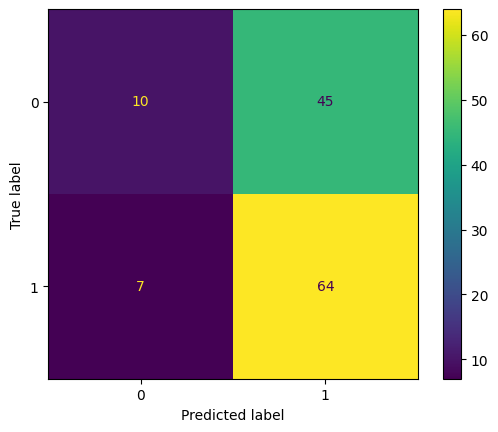

In [92]:
ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
# plot the confusion matrix for the logistic regression model

# Value of 0,0 and 1,1 means model successfully predicted the label,
# while value of 1,0 and 0,1 means model get the wrong prediction
plt.show()


We now try to use reinforcement to do more advanced machine learning.

In [47]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import math
import numpy as np
import random
from collections import deque

The code sets up a reinforcement learning agent with a neural network model that learns to make decisions (buying, selling, or sitting) in a stock trading environment. The agent learns from its experiences using the Q-learning algorithm and improves its performance over time through repeated interactions with the environment.

The act method determines the agent's action based on the current state. The neural network model predicts the Q-values for the current state. These predicted Q-values correspond to the estimated future rewards for each possible action the agent can take. The agent then chooses the action with the highest predicted Q-value, unless it is in evaluation mode (is_eval=True) or randomly selected due to exploration.

The expReplay method implements experience replay. It samples a batch of experiences from the memory and updates the model's weights based on the Bellman equation, which estimates the optimal action-value function (Q-value).

In [48]:

class Agent:
# Agent class
    def __init__(self, state_size, is_eval=False, model_name=""):
        """Initialize Agent class"""
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000) # internal memory
        self.inventory = [] # inventory
        self.model_name = model_name # name of the model
        self.is_eval = is_eval # evaluation flag
        self.gamma = 0.95 # discount rate
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01 # minimum exploration probability
        self.epsilon_decay = 0.995 # exponential decay rate for exploration prob
        self.model = load_model(model_name) if is_eval else self._model() # load model if is_eval is true, else create a new model
    def _model(self):
        """Neural Network Model"""
        # create a neural network model with 3 hidden layers
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        # mean squared error loss, adam optimizer
        return model
    def act(self, state):
        """Agent will act upon the current state"""
        if not self.is_eval and random.random()<= self.epsilon:
            return random.randrange(self.action_size)
        # explore
        options = self.model.predict(state)
        # predict the reward value based on the given state
        return np.argmax(options[0])
        # pick the action based on the predicted reward
    def expReplay(self, batch_size):
        """Experience Replay"""
        mini_batch = []
        # sample a minibatch from the memory
        l = len(self.memory)
        # how many memories do we have
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        # extract information from the minibatch
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        # train the neural network with the state and target_f

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        # decrease the exploration probability

In [49]:
def formatPrice(n):
    """Format price"""
    return("-$." if n<0 else "$.")+"{0:.2f}".format(abs(n)) # format price as $x.xx


def sigmoid(x):
    """Sigmoid function"""
    return 1/(1+math.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def getState(data, t, n):
    """Get state"""
    d = t - n + 1 # t = timestep, n = window size
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    res = [] # list of price changes
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i])) # calculate price change
    return np.array([res]) # return array of price changes

The code below performs the training loop for the reinforcement learning agent in the stock trading environment. It interacts with the environment, executes actions, and updates the agent's neural network model based on the observed rewards.

One thing to note is the agent's memory. The agent's memory is used for experience replay, which is a technique in reinforcement learning that helps improve the agent's learning efficiency and stability. During the training process, the agent samples a batch of experiences from its memory and uses them to update its model through a process called experience replay. This helps the agent learn from a diverse set of experiences and reduces the correlation between consecutive samples.

In [54]:
import sys
window_size = input()
episode_count = input() # number of episodes
window_size = int(window_size)
#window size represents the length of the historical sequence of stock prices that the agent
#uses as its input state.
#By setting a larger window size, the agent can capture more historical price patterns
#and potentially make more informed decisions
episode_count = int(episode_count)
agent = Agent(window_size) # initialize agent
data=list(price_df['Close'][1000:]) # get the stock data
l = len(data) - 1 # data length
batch_size = 10000 # minibatch size
for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count)) # print the episode number
    state = getState(data, 0, window_size + 1) # get initial state
    total_profit = 0 # initialize total profit
    agent.inventory = [] # initialize inventory
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data, t + 1, window_size + 1) # get the next state
        reward = 0 # initialize reward
        if action == 1: # buy
            agent.inventory.append(data[t]) # add shares
            print("Buy: " + formatPrice(data[t])) # print action
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = window_size_price = agent.inventory.pop(0) # sell shares
            reward = max(data[t] - bought_price, 0) # calculate reward
            total_profit += data[t] - bought_price # update total profit
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price)) # print action
        done = True if t == l - 1 else False # determine if episode is finished
        agent.memory.append((state, action, reward, next_state, done)) # append memory
        state = next_state # update state
        if done: # print the result if episode is finished
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit)) # print total profit
            print("--------------------------------")
        if len(agent.memory) > batch_size: # train the agent with the experience of the episode
            agent.expReplay(batch_size) # train the agent
        if e % 2 == 0: # save the agent model every 2 episodes
            agent.model.save(str(e)) # save the agent model

4
6


Episode 0/6


Buy: $.147.96


Buy: $.142.64


Sell: $.137.13 | Profit: -$.10.83


Sell: $.131.88 | Profit: -$.10.76


Buy: $.130.06


Sell: $.138.27 | Profit: $.8.21


Buy: $.141.66


Buy: $.139.23


Sell: $.136.72 | Profit: -$.4.94


Buy: $.138.93


Sell: $.141.56 | Profit: $.2.33


Buy: $.142.92


Buy: $.146.35


Buy: $.147.04


Sell: $.144.87 | Profit: $.5.94


Sell: $.145.49 | Profit: $.2.57


Sell: $.148.47 | Profit: $.2.12


Sell: $.151.00 | Profit: $.3.96


Buy: $.153.04


Buy: $.155.35


Sell: $.154.09 | Profit: $.1.05


Sell: $.152.95 | Profit: -$.2.40


Buy: $.151.60


Buy: $.162.51


Buy: $.160.01


Buy: $.166.13


Buy: $.165.35


Sell: $.164.87 | Profit: $.13.27


Sell: $.168.49 | Profit: $.5.98


Sell: $.173.03 | Profit: $.13.02


Buy: $.174.55


Sell: $.171.52 | Profit: $.5.39


Buy: $.167.57


Buy: $.167.23


Buy: $.163.62


Buy: $.161.38


Buy: $.158.91


Buy: $.157.22


Buy: $.157.96


Sell: $.154.53 | Profit: -$.10.82


Sell: $.155.96 | Profit: -$.18.59


Sell: $.154.46 | Profit: -$.13.11


Buy: $.157.37


Sell: $.153.84 | Profit: -$.13.39


Sell: $.152.37 | Profit: -$.11.25


Sell: $.150.70 | Profit: -$.10.68


Buy: $.154.48


Buy: $.156.90


Sell: $.152.74 | Profit: -$.6.17


Buy: $.150.43


Buy: $.150.77


Sell: $.151.76 | Profit: -$.5.46


Buy: $.149.84


Sell: $.138.20 | Profit: -$.19.76


Sell: $.146.40 | Profit: -$.10.97


Sell: $.145.43 | Profit: -$.9.05


Buy: $.140.09


Sell: $.140.42 | Profit: -$.16.48


Buy: $.138.98


Buy: $.138.38


Buy: $.142.41


Buy: $.143.75


Buy: $.143.86


Buy: $.143.39


Sell: $.149.45 | Profit: -$.0.98


Buy: $.152.34


Sell: $.149.35 | Profit: -$.1.42


Sell: $.144.80 | Profit: -$.5.04


Sell: $.153.34 | Profit: $.13.25


Sell: $.150.65 | Profit: $.11.67


Sell: $.145.03 | Profit: $.6.65


Buy: $.138.88


Buy: $.138.38


Sell: $.138.92 | Profit: -$.3.49


Sell: $.139.50 | Profit: -$.4.25


Sell: $.134.87 | Profit: -$.8.99


Buy: $.149.70


Sell: $.150.04 | Profit: $.6.65


Sell: $.148.79 | Profit: -$.3.55


Buy: $.150.72


Buy: $.151.29


Sell: $.148.01 | Profit: $.9.13


Buy: $.150.18


Sell: $.151.07 | Profit: $.12.69


Buy: $.148.11


Sell: $.146.63 | Profit: -$.3.07


Buy: $.140.94


Buy: $.142.65


Buy: $.142.16


Sell: $.144.49 | Profit: -$.6.23


Buy: $.145.47


Buy: $.143.21


Buy: $.136.50


Sell: $.134.51 | Profit: -$.16.78


Sell: $.132.37 | Profit: -$.17.81


Buy: $.132.30


Sell: $.132.23 | Profit: -$.15.88


Buy: $.129.61


Sell: $.129.93 | Profit: -$.11.01


Buy: $.125.07


Buy: $.126.36


Buy: $.125.02


Sell: $.129.62 | Profit: -$.13.03


Buy: $.130.15


Buy: $.130.73


Sell: $.133.41 | Profit: -$.8.75


Sell: $.134.76 | Profit: -$.10.71


Buy: $.135.21


Sell: $.135.27 | Profit: -$.7.94


Buy: $.141.11


Buy: $.142.53


Buy: $.141.86


Sell: $.143.96 | Profit: $.7.46


Sell: $.145.93 | Profit: $.13.63


Sell: $.145.43 | Profit: $.15.82


Sell: $.150.82 | Profit: $.25.75


Buy: $.151.73


Sell: $.154.65 | Profit: $.28.29


Buy: $.151.92


Sell: $.150.87 | Profit: $.25.85


Buy: $.151.01


Sell: $.153.20 | Profit: $.23.05


Sell: $.155.33 | Profit: $.24.60


Buy: $.152.55


Buy: $.148.48


Buy: $.146.71


Sell: $.147.92 | Profit: $.12.71


Buy: $.147.41


Sell: $.145.91 | Profit: $.4.80


Sell: $.151.03 | Profit: $.8.50


Sell: $.153.83 | Profit: $.11.97


Sell: $.152.87 | Profit: $.1.14


Buy: $.148.50


Buy: $.150.47


Buy: $.152.59


Buy: $.152.99


Sell: $.155.85 | Profit: $.3.93


Sell: $.155.00 | Profit: $.3.99


Buy: $.157.83


Sell: $.158.93 | Profit: $.6.38


Sell: $.157.65 | Profit: $.9.17


Sell: $.162.36 | Profit: $.15.65


Buy: $.160.80


Sell: $.165.56 | Profit: $.18.15


Sell: $.165.21 | Profit: $.16.71


Buy: $.165.23


Buy: $.167.63


Buy: $.166.65


Sell: $.165.02 | Profit: $.14.55


Sell: $.163.77 | Profit: $.11.18


Sell: $.168.41 | Profit: $.15.42


Sell: $.169.68 | Profit: $.11.85


Sell: $.167.45 | Profit: $.6.65


Sell: $.173.50 | Profit: $.8.27


Buy: $.172.57


Buy: $.172.07


Buy: $.175.05


Buy: $.174.20


Buy: $.171.56


Buy: $.171.84


Sell: $.177.30 | Profit: $.9.67


Sell: $.177.25 | Profit: $.10.60


Buy: $.180.09


Buy: $.180.95


Sell: $.179.58 | Profit: $.7.01


Sell: $.179.21 | Profit: $.7.14


Buy: $.180.57


Sell: $.183.31 | Profit: $.8.26
--------------------------------
Total Profit: $.198.44
--------------------------------


Episode 1/6
Buy: $.135.43
Buy: $.130.06
Buy: $.131.56
Sell: $.135.87 | Profit: $.0.44
Buy: $.135.35
Buy: $.139.23
Buy: $.138.93
Sell: $.141.56 | Profit: $.11.50
Buy: $.142.92
Sell: $.147.04 | Profit: $.15.48
Sell: $.144.87 | Profit: $.9.52
Sell: $.145.86 | Profit: $.6.63
Buy: $.145.49
Buy: $.148.47
Buy: $.147.07
Buy: $.153.04
Sell: $.155.35 | Profit: $.16.42
Buy: $.154.09
Sell: $.152.95 | Profit: $.10.03
Buy: $.156.79
Buy: $.157.35
Sell: $.162.51 | Profit: $.17.02
Sell: $.160.01 | Profit: $.11.54
Sell: $.166.13 | Profit: $.19.06
Sell: $.165.81 | Profit: $.12.77
Buy: $.164.87
Buy: $.164.92
Buy: $.172.10
Sell: $.174.15 | Profit: $.20.06
Buy: $.171.52
Buy: $.167.57
Sell: $.167.23 | Profit: $.10.44
Buy: $.167.53
Sell: $.163.62 | Profit: $.6.27
Buy: $.161.38
Buy: $.158.91
Buy: $.155.81
Sell: $.154.53 | Profit: -$.10.34
Sell: $.155.96 | Profit: -$.8.96
Sell: $.154.46 | Profit: -$.17.64
Buy: $.157.37
Sell: $.152.37 | Profit: -$.19.15
Buy: $.156.90
Buy: $.153.72
Sell: $.152.74 | Profit: -$.14.

Sell: $.147.96 | Profit: $.1.82


Buy: $.142.64


Buy: $.137.13


Sell: $.131.88 | Profit: -$.10.76


Buy: $.132.76


Sell: $.135.43 | Profit: -$.1.70


Buy: $.131.56


Sell: $.135.35 | Profit: $.2.59


Buy: $.138.27


Buy: $.141.66


Buy: $.141.66


Buy: $.137.44


Buy: $.139.23


Sell: $.138.93 | Profit: $.7.37


Buy: $.142.92


Sell: $.146.35 | Profit: $.8.08


Buy: $.148.47


Buy: $.150.17


Buy: $.147.07


Sell: $.151.00 | Profit: $.9.34


Sell: $.152.95 | Profit: $.11.29


Buy: $.161.51


Sell: $.160.01 | Profit: $.22.57


Sell: $.165.81 | Profit: $.26.58


Buy: $.164.92


Buy: $.168.49


Sell: $.172.10 | Profit: $.29.18


Sell: $.173.03 | Profit: $.24.56


Buy: $.174.15


Buy: $.167.23


Sell: $.170.03 | Profit: $.19.86


Buy: $.161.38


Sell: $.158.91 | Profit: $.11.84


Sell: $.157.96 | Profit: -$.3.55


Buy: $.155.81


Sell: $.154.53 | Profit: -$.10.39


Buy: $.155.96


Buy: $.154.46


Sell: $.163.43 | Profit: -$.5.06


Buy: $.155.31


Buy: $.152.37


Buy: $.150.70


Buy: $.154.48


Sell: $.153.72 | Profit: -$.20.43


Buy: $.152.74


Buy: $.150.43


Sell: $.150.77 | Profit: -$.16.46


Sell: $.151.76 | Profit: -$.9.62


Sell: $.146.10 | Profit: -$.9.71


Sell: $.145.43 | Profit: -$.10.53


Sell: $.140.09 | Profit: -$.14.37


Sell: $.138.34 | Profit: -$.16.97


Sell: $.142.99 | Profit: -$.9.38


Buy: $.138.38


Buy: $.143.39


Sell: $.147.27 | Profit: -$.3.43


Sell: $.149.45 | Profit: -$.5.03


Buy: $.149.35


Buy: $.155.74


Sell: $.153.34 | Profit: $.0.60


Sell: $.150.65 | Profit: $.0.22


Sell: $.145.03 | Profit: $.6.65


Sell: $.138.88 | Profit: -$.4.51


Sell: $.138.92 | Profit: -$.10.43


Buy: $.139.50


Buy: $.134.87


Sell: $.146.87 | Profit: -$.8.87


Sell: $.149.70 | Profit: $.10.20


Buy: $.150.04


Sell: $.150.72 | Profit: $.15.85


Buy: $.151.29


Sell: $.148.01 | Profit: -$.2.03


Buy: $.151.07


Sell: $.148.11 | Profit: -$.3.18


Sell: $.144.22 | Profit: -$.6.85


Buy: $.148.03


Sell: $.148.31 | Profit: $.0.28


Buy: $.142.91


Sell: $.140.94 | Profit: -$.1.97


Buy: $.142.65


Buy: $.142.16


Sell: $.144.49 | Profit: $.1.84


Sell: $.145.47 | Profit: $.3.31


Buy: $.131.86


Sell: $.126.04 | Profit: -$.5.82


Buy: $.129.93


Sell: $.126.36 | Profit: -$.3.57


Buy: $.129.62


Buy: $.134.76


Sell: $.135.21 | Profit: $.5.59


Buy: $.135.27


Sell: $.142.53 | Profit: $.7.77


Buy: $.145.93


Buy: $.143.00


Buy: $.144.29


Buy: $.145.43


Sell: $.150.82 | Profit: $.15.55


Buy: $.154.50


Sell: $.151.73 | Profit: $.5.80


Buy: $.154.65


Buy: $.151.92


Buy: $.150.87


Buy: $.153.85


Buy: $.155.33


Sell: $.153.71 | Profit: $.10.71


Buy: $.152.55


Buy: $.148.48


Sell: $.148.91 | Profit: $.4.62


Sell: $.149.40 | Profit: $.3.97


Sell: $.146.71 | Profit: -$.7.79


Buy: $.147.92


Sell: $.147.41 | Profit: -$.7.24


Buy: $.145.31


Sell: $.145.91 | Profit: -$.6.01


Sell: $.153.83 | Profit: $.2.96


Sell: $.151.60 | Profit: -$.2.25


Sell: $.152.87 | Profit: -$.2.46


Sell: $.148.50 | Profit: -$.4.05


Sell: $.150.47 | Profit: $.1.99


Buy: $.152.99


Buy: $.155.85


Buy: $.155.00


Buy: $.159.28


Sell: $.157.83 | Profit: $.9.91


Buy: $.158.93


Sell: $.158.28 | Profit: $.12.97


Buy: $.157.65


Buy: $.162.36


Buy: $.164.90


Buy: $.165.63


Sell: $.164.66 | Profit: $.11.67


Sell: $.162.03 | Profit: $.6.18


Sell: $.160.80 | Profit: $.5.80


Sell: $.165.56 | Profit: $.6.28


Buy: $.165.21


Sell: $.165.23 | Profit: $.6.30


Sell: $.166.65 | Profit: $.9.00


Sell: $.165.02 | Profit: $.2.66


Buy: $.165.33


Sell: $.163.76 | Profit: -$.1.14


Sell: $.169.68 | Profit: $.4.05


Buy: $.169.59


Sell: $.168.54 | Profit: $.3.33


Buy: $.167.45


Buy: $.165.79


Sell: $.173.57 | Profit: $.8.24


Sell: $.173.50 | Profit: $.3.91


Sell: $.171.77 | Profit: $.4.32


Sell: $.173.56 | Profit: $.7.77


Buy: $.173.75


Buy: $.172.57


Sell: $.172.07 | Profit: -$.1.68


Sell: $.175.05 | Profit: $.2.48


Buy: $.175.16


Sell: $.171.56 | Profit: -$.3.60


Buy: $.175.43


Buy: $.177.30


Buy: $.177.25


Buy: $.180.09


Buy: $.177.82


Buy: $.180.57


Buy: $.180.96


Sell: $.183.79 | Profit: $.8.36


Sell: $.183.31 | Profit: $.6.01
--------------------------------
Total Profit: $.161.39
--------------------------------


Episode 3/6
Buy: $.146.14
Sell: $.147.96 | Profit: $.1.82
Buy: $.142.64
Sell: $.131.88 | Profit: -$.10.76
Buy: $.132.76
Buy: $.131.56
Sell: $.135.35 | Profit: $.2.59
Buy: $.138.27
Sell: $.141.66 | Profit: $.10.10
Sell: $.141.66 | Profit: $.3.39
Buy: $.146.35
Buy: $.147.04
Buy: $.148.47
Sell: $.147.07 | Profit: $.0.72
Sell: $.151.00 | Profit: $.3.96
Buy: $.153.04
Sell: $.155.35 | Profit: $.6.88
Buy: $.154.09
Sell: $.151.60 | Profit: -$.1.44
Sell: $.156.79 | Profit: $.2.70
Buy: $.162.51
Buy: $.161.51
Sell: $.160.01 | Profit: -$.2.50
Sell: $.165.81 | Profit: $.4.30
Buy: $.165.35
Sell: $.164.92 | Profit: -$.0.43
Buy: $.172.10
Sell: $.173.19 | Profit: $.1.09
Buy: $.171.52
Buy: $.167.57
Buy: $.167.23
Buy: $.167.53
Buy: $.170.03
Buy: $.163.62
Buy: $.157.22
Buy: $.157.96
Sell: $.155.81 | Profit: -$.15.71
Buy: $.157.37
Buy: $.163.43
Sell: $.153.84 | Profit: -$.13.73
Buy: $.155.31
Buy: $.152.37
Sell: $.156.90 | Profit: -$.10.33
Buy: $.152.74
Sell: $.150.43 | Profit: -$.17.10
Sell: $.151.76 | Pro

Buy: $.147.96


Buy: $.137.13


Buy: $.132.76


Buy: $.135.43


Sell: $.130.06 | Profit: -$.17.90


Buy: $.135.87


Buy: $.135.35


Sell: $.138.27 | Profit: $.1.14


Buy: $.137.44


Buy: $.139.23


Sell: $.138.93 | Profit: $.6.17


Sell: $.141.56 | Profit: $.6.13


Sell: $.142.92 | Profit: $.7.05


Sell: $.147.04 | Profit: $.11.69


Sell: $.151.00 | Profit: $.13.56


Buy: $.153.04


Sell: $.155.35 | Profit: $.16.12


Buy: $.154.09


Buy: $.151.60


Buy: $.156.79


Sell: $.161.51 | Profit: $.8.47


Buy: $.160.01


Sell: $.165.81 | Profit: $.11.72


Buy: $.164.92


Sell: $.168.49 | Profit: $.16.89


Sell: $.173.19 | Profit: $.16.40


Buy: $.173.03


Sell: $.171.52 | Profit: $.11.51


Buy: $.167.57


Buy: $.167.53


Buy: $.170.03


Buy: $.158.91


Sell: $.157.22 | Profit: -$.7.70


Buy: $.157.96


Buy: $.155.81


Sell: $.154.53 | Profit: -$.18.50


Sell: $.155.96 | Profit: -$.11.61


Sell: $.157.37 | Profit: -$.10.16


Buy: $.155.31


Buy: $.152.37


Sell: $.150.70 | Profit: -$.19.33


Sell: $.152.74 | Profit: -$.6.17


Buy: $.150.43


Sell: $.150.77 | Profit: -$.7.19


Sell: $.149.84 | Profit: -$.5.97


Buy: $.142.48


Buy: $.142.45


Sell: $.146.10 | Profit: -$.9.21


Sell: $.146.40 | Profit: -$.5.97


Sell: $.145.43 | Profit: -$.5.00


Sell: $.140.09 | Profit: -$.2.39


Buy: $.138.34


Sell: $.142.99 | Profit: $.0.54


Sell: $.138.38 | Profit: $.0.04


Buy: $.142.41


Buy: $.143.75


Buy: $.143.39


Sell: $.149.45 | Profit: $.7.04


Buy: $.152.34


Sell: $.144.80 | Profit: $.1.05


Sell: $.155.74 | Profit: $.12.35


Buy: $.150.65


Sell: $.145.03 | Profit: -$.7.31


Sell: $.139.50 | Profit: -$.11.15


Buy: $.134.87


Buy: $.146.87


Sell: $.150.04 | Profit: $.15.17


Sell: $.150.72 | Profit: $.3.85


Buy: $.144.22


Sell: $.141.17 | Profit: -$.3.05


Buy: $.146.63


Buy: $.140.94


Sell: $.144.49 | Profit: -$.2.14


Buy: $.136.50


Buy: $.134.51


Buy: $.132.30


Sell: $.135.45 | Profit: -$.5.49


Buy: $.126.04


Sell: $.129.61 | Profit: -$.6.89


Buy: $.129.93


Sell: $.125.07 | Profit: -$.9.44


Buy: $.126.36


Sell: $.125.02 | Profit: -$.7.28


Sell: $.129.62 | Profit: $.3.58


Sell: $.130.15 | Profit: $.0.22


Buy: $.130.73


Buy: $.133.49


Buy: $.133.41


Sell: $.134.76 | Profit: $.8.40


Sell: $.135.94 | Profit: $.5.21


Sell: $.137.87 | Profit: $.4.38


Sell: $.141.11 | Profit: $.7.70


Buy: $.142.53


Sell: $.141.86 | Profit: -$.0.67


Buy: $.150.82


Buy: $.154.65


Sell: $.150.87 | Profit: $.0.05


Buy: $.151.01


Sell: $.153.85 | Profit: -$.0.80


Buy: $.148.91


Buy: $.149.40


Buy: $.147.92


Buy: $.147.41


Buy: $.145.31


Sell: $.151.03 | Profit: $.0.02


Sell: $.151.60 | Profit: $.2.69


Buy: $.152.87


Buy: $.148.50


Buy: $.150.47


Buy: $.152.99


Buy: $.155.00


Buy: $.157.40


Sell: $.159.28 | Profit: $.9.88


Sell: $.158.93 | Profit: $.11.01


Sell: $.157.65 | Profit: $.10.24


Buy: $.162.36


Sell: $.166.17 | Profit: $.20.86


Buy: $.165.63


Sell: $.164.66 | Profit: $.11.79


Buy: $.162.03


Buy: $.165.56


Sell: $.165.21 | Profit: $.16.71


Buy: $.165.23


Sell: $.166.47 | Profit: $.16.00


Buy: $.167.63


Buy: $.165.02


Buy: $.165.33


Sell: $.163.77 | Profit: $.10.78


Buy: $.168.41


Sell: $.169.68 | Profit: $.14.68


Buy: $.168.54


Buy: $.173.50


Buy: $.171.77


Sell: $.173.56 | Profit: $.16.16


Buy: $.173.75


Buy: $.172.57


Buy: $.172.07


Buy: $.172.07


Buy: $.172.69


Buy: $.175.05


Buy: $.174.20


Buy: $.171.56


Buy: $.171.84


Buy: $.172.99


Buy: $.175.43


Buy: $.180.95


Sell: $.179.58 | Profit: $.17.22


Sell: $.179.21 | Profit: $.13.58


Sell: $.177.82 | Profit: $.15.79


Sell: $.180.96 | Profit: $.15.40


Buy: $.183.79


Sell: $.183.31 | Profit: $.18.08
--------------------------------
Total Profit: $.236.00
--------------------------------


Episode 5/6
Buy: $.147.96
Buy: $.137.13
Buy: $.131.88
Sell: $.132.76 | Profit: -$.15.20
Sell: $.135.43 | Profit: -$.1.70
Sell: $.130.06 | Profit: -$.1.82
Buy: $.138.27
Sell: $.141.66 | Profit: $.3.39
Buy: $.141.66
Sell: $.137.44 | Profit: -$.4.22
Buy: $.139.23
Buy: $.136.72
Buy: $.141.56
Sell: $.142.92 | Profit: $.3.69
Buy: $.146.35
Buy: $.144.87
Sell: $.148.47 | Profit: $.11.75
Sell: $.155.35 | Profit: $.13.79
Sell: $.154.09 | Profit: $.7.74
Sell: $.152.95 | Profit: $.8.08
Buy: $.162.51
Sell: $.161.51 | Profit: -$.1.00
Buy: $.169.24
Buy: $.172.10
Buy: $.173.19
Sell: $.173.03 | Profit: $.3.79
Buy: $.174.55
Buy: $.174.15
Buy: $.171.52
Buy: $.167.57
Sell: $.167.23 | Profit: -$.4.87
Buy: $.167.53
Buy: $.170.03
Sell: $.161.38 | Profit: -$.11.81
Buy: $.157.96
Sell: $.155.81 | Profit: -$.18.74
Sell: $.154.53 | Profit: -$.19.62
Sell: $.155.96 | Profit: -$.15.56
Buy: $.163.43
Buy: $.153.84
Sell: $.155.31 | Profit: -$.12.26
Sell: $.152.37 | Profit: -$.15.16
Buy: $.154.48
Sell: $.156.90 | Profit

Buy: $.148.71


Sell: $.142.64 | Profit: -$.6.07


Buy: $.131.56


Buy: $.135.87


Buy: $.138.27


Buy: $.141.66


Buy: $.137.44


Sell: $.139.23 | Profit: $.7.67


Sell: $.138.93 | Profit: $.3.06


Sell: $.141.56 | Profit: $.3.29


Sell: $.142.92 | Profit: $.1.26


Sell: $.146.35 | Profit: $.8.91


Buy: $.148.47


Sell: $.150.17 | Profit: $.1.70


Buy: $.155.35


Buy: $.156.79


Sell: $.157.35 | Profit: $.2.00


Sell: $.162.51 | Profit: $.5.72


Buy: $.165.81


Sell: $.165.35 | Profit: -$.0.46


Buy: $.164.92


Sell: $.168.49 | Profit: $.3.57


Buy: $.173.03


Buy: $.174.15


Sell: $.167.57 | Profit: -$.5.46


Buy: $.167.23


Sell: $.158.91 | Profit: -$.15.24


Buy: $.157.96


Buy: $.155.81


Sell: $.157.37 | Profit: -$.9.86


Sell: $.152.37 | Profit: -$.5.59


Buy: $.154.48


Sell: $.156.90 | Profit: $.1.09


Buy: $.153.72


Sell: $.152.74 | Profit: -$.1.74


Buy: $.150.43


Sell: $.150.77 | Profit: -$.2.95


Buy: $.151.76


Sell: $.149.84 | Profit: -$.0.59


Sell: $.138.20 | Profit: -$.13.56


Buy: $.140.09


Sell: $.138.98 | Profit: -$.1.11


Buy: $.138.34


Sell: $.142.99 | Profit: $.4.65


Buy: $.142.41


Buy: $.143.75


Buy: $.143.86


Buy: $.149.45


Buy: $.152.34


Buy: $.149.35


Buy: $.153.34


Buy: $.145.03


Sell: $.138.88 | Profit: -$.3.53


Buy: $.138.38


Buy: $.138.92


Sell: $.139.50 | Profit: -$.4.25


Sell: $.134.87 | Profit: -$.8.99


Sell: $.149.70 | Profit: $.0.25


Sell: $.148.28 | Profit: -$.4.06


Buy: $.150.04


Buy: $.148.79


Buy: $.150.72


Buy: $.151.29


Sell: $.150.18 | Profit: $.0.83


Sell: $.144.22 | Profit: -$.9.12


Buy: $.141.17


Sell: $.148.31 | Profit: $.3.28


Sell: $.146.63 | Profit: $.8.25


Buy: $.140.94


Buy: $.142.16


Sell: $.144.49 | Profit: $.5.57


Sell: $.145.47 | Profit: -$.4.57


Sell: $.143.21 | Profit: -$.5.58


Buy: $.132.37


Buy: $.135.45


Buy: $.132.23


Sell: $.131.86 | Profit: -$.18.86


Sell: $.130.03 | Profit: -$.21.26


Sell: $.129.61 | Profit: -$.11.56


Buy: $.129.93


Buy: $.125.07


Buy: $.125.02


Buy: $.129.62


Buy: $.130.15


Buy: $.130.73


Sell: $.133.41 | Profit: -$.7.53


Sell: $.135.94 | Profit: -$.6.22


Buy: $.135.21


Sell: $.141.11 | Profit: $.8.74


Sell: $.142.53 | Profit: $.7.08


Buy: $.141.86


Buy: $.145.93


Sell: $.144.29 | Profit: $.12.06


Buy: $.145.43


Buy: $.154.50


Buy: $.151.73


Sell: $.154.65 | Profit: $.24.72


Buy: $.151.92


Buy: $.150.87


Buy: $.151.01


Buy: $.153.85


Buy: $.153.20


Sell: $.155.33 | Profit: $.30.26


Sell: $.148.48 | Profit: $.23.46


Sell: $.148.91 | Profit: $.19.29


Sell: $.146.71 | Profit: $.16.56


Buy: $.147.92


Buy: $.145.31


Sell: $.153.83 | Profit: $.23.10


Buy: $.148.50


Sell: $.150.47 | Profit: $.15.26


Buy: $.152.59


Sell: $.155.85 | Profit: $.13.99


Buy: $.155.00


Buy: $.159.28


Sell: $.157.83 | Profit: $.11.90


Buy: $.158.93


Sell: $.160.25 | Profit: $.14.82


Sell: $.162.36 | Profit: $.7.86


Sell: $.165.63 | Profit: $.13.90


Buy: $.164.66


Buy: $.165.21


Sell: $.166.47 | Profit: $.14.55


Buy: $.167.63


Sell: $.166.65 | Profit: $.15.78


Sell: $.165.02 | Profit: $.14.01


Buy: $.165.33


Buy: $.163.77


Sell: $.163.76 | Profit: $.9.91


Buy: $.168.41


Sell: $.169.59 | Profit: $.16.39


Buy: $.168.54


Sell: $.173.57 | Profit: $.25.65


Sell: $.172.57 | Profit: $.27.26


Sell: $.172.07 | Profit: $.23.57


Buy: $.172.07


Sell: $.172.69 | Profit: $.20.10


Sell: $.175.05 | Profit: $.20.05


Sell: $.171.56 | Profit: $.12.28


Buy: $.171.84


Sell: $.175.43 | Profit: $.16.50


Sell: $.177.30 | Profit: $.12.64


Sell: $.180.95 | Profit: $.15.74


Sell: $.179.58 | Profit: $.11.95


Sell: $.180.57 | Profit: $.15.24


Sell: $.180.96 | Profit: $.17.19


Buy: $.183.79


--------------------------------
Total Profit: $.424.75
--------------------------------


In [55]:
# change the data to test data and run the same code as above to test the model.
model_name = input()
model = load_model(model_name)
window_size = model.layers[0].input.shape.as_list()[1]
agent = Agent(window_size, True, model_name)
data=list(price_df['Close'][1000:])
print(data)
l = len(data) - 1
batch_size = 10000
state = getState(data, 0, window_size + 1)
print(state)
total_profit = 0
agent.inventory = []
print(l)
for t in range(l):
    action = agent.act(state)
    print(action)
    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0
    if action == 1: # buy
        agent.inventory.append(data[t])
        print("Buy: " + formatPrice(data[t]))
    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    if done:
        print("--------------------------------")
        print(ticker + " Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")
        print ("Total profit is:",formatPrice(total_profit))

0
[146.13999938964844, 148.7100067138672, 147.9600067138672, 142.63999938964844, 137.1300048828125, 131.8800048828125, 132.75999450683594, 135.42999267578125, 130.05999755859375, 131.55999755859375, 135.8699951171875, 135.35000610351562, 138.27000427246094, 141.66000366210938, 141.66000366210938, 137.44000244140625, 139.22999572753906, 136.72000122070312, 138.92999267578125, 141.55999755859375, 142.9199981689453, 146.35000610351562, 147.0399932861328, 144.8699951171875, 145.86000061035156, 145.49000549316406, 148.47000122070312, 150.1699981689453, 147.07000732421875, 151.0, 153.0399932861328, 155.35000610351562, 154.08999633789062, 152.9499969482422, 151.60000610351562, 156.7899932861328, 157.35000610351562, 162.50999450683594, 161.50999450683594, 160.00999450683594, 166.1300048828125, 165.80999755859375, 165.35000610351562, 164.8699951171875, 164.9199981689453, 169.24000549316406, 168.49000549316406, 172.10000610351562, 173.19000244140625, 173.02999877929688, 174.5500030517578, 174.14

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2ec7deb9-abbc-4b73-ad7f-dbdabce8c881' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>